<p align="center"><span style="color:#00cc00; text-decoration:underline; font-size:1.5em;"><i>FINAL PROYECT JOF</i></span></p>

<p align="center"><span style="color:#00cc00; text-decoration:underline; font-size:1.2em;"><i>Renewable Power Generation and weather Conditions</i></span></p>

![alt text](vecteezy_solar-panel-with-blue-sky-and-sunset-concept-clean-energy_8423306.jpg)

# Paso 1: definición del problema

**¡Hola a todos! Somos estudiantes del Bootcamp de Ciencia de Datos y Aprendizaje Automático: Javier Serrano, Olga Kurganova y Fernando Tejada. Para nuestro proyecto final, hemos decidido trabajar con un conjunto de datos que registra la energía recolectada por un panel solar en una ubicación geográfica específica. Además, el conjunto de datos incluye variables relacionadas con las condiciones climáticas, el tiempo cronológico y la variación en la cantidad de energía producida, todas las cuales pueden influir en la cantidad de radiación solar que el panel recoge, incluida la "Irradiancia Global Horizontal" (IGH):**

*Hello everyone! We are students of the Data Science & Machine Learning Bootcamp: Javier Serrano, Olga Kurganova, and Fernando Tejada. For our final project, we have decided to work with a dataset that records the energy collected by a solar panel in a specific geographical location. Additionally, the dataset includes variables related to weather conditions, chronological time and the variation in the amount of energy produced, all of which can influence in the amount of solar radiation the panel collects, including the "Global Horizontal Irradiance" (GHI):*

- Time                                      
- Energy delta [Wh]  **(target)**                        
- GHI (Global Horizontal Irradiance)        
- Temp                                     
- Pressure                                 
- Humidity
- Wind_speed                                  
- Rain_1h                                  
- Snow_1h                                 
- Clouds_all                                
- isSun_category                                     
- SunlightTime                             
- DayLength                                 
- SunlightTime/dayLength                    
- Weather_type                             
- Hour                                     
- Month    

**Gracias a este conjunto de datos, podremos crear un modelo de Aprendizaje Automático que nos permita determinar si la instalación de paneles solares es viable basándonos en la cantidad de energía que pueden recolectar (Energy delta [Wh]) y las condiciones climáticas en el sitio de instalación elegido. De esta manera, crearemos una herramienta que permita tanto a individuos locales como a empresas del sector energético verificar si es rentable invertir en la instalación de paneles solares.**

*Thanks to this dataset, we will be able to create a Machine Learning model that allows us to determine whether the installation of solar panels is viable based on the amount of energy they can collect and the weather conditions at the chosen installation site. In this way, we will create a tool that enables both local individuals and energy sector companies to verify whether it is profitable to invest in the installation of solar panels.*

# Paso 2: Obtención y carga del conjunto de datos

In [2]:
# import libraries

import pandas as pd
from sqlalchemy import create_engine
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import optuna


In [3]:
raw_data = pd.read_csv("/workspaces/Final-Project-JOF/data/raw/new_data.csv")
raw_data.head()

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month,isSun_category
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0,very cloudy,0,January,No
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0,very cloudy,0,January,No
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0,very cloudy,0,January,No
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0,very cloudy,0,January,No
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,450,0.0,very cloudy,1,January,No


 se ha cambiado a categórica: weather type, month y IsSun_category

# Paso 3: almacenar la información

In [4]:
engine = create_engine('sqlite:///solar_data.db')

In [5]:
raw_data.to_sql('solar_data', engine, index=False, if_exists='replace')

196776

In [6]:
# Consulta 1: Los 5 registros de energy delta más altos
query1 = """
SELECT * FROM solar_data
ORDER BY "Energy delta[Wh]" DESC
LIMIT 5
"""
top_5_energy_delta = pd.read_sql(query1, engine)
print("Top 5 registros de Energy delta más altos:")
top_5_energy_delta

Top 5 registros de Energy delta más altos:


,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month,isSun_category
0,2021-04-28 10:30:00,5020,204.9,12.7,1011,39,5.9,0.0,0.0,68,435,900,0.48,cloudy,10,April,Yes
1,2018-03-17 10:45:00,4913,148.5,-3.0,1019,43,8.2,0.0,0.0,95,345,705,0.49,very cloudy,10,March,Yes
2,2020-03-22 11:00:00,4897,167.5,2.7,1038,39,5.0,0.0,0.0,58,375,735,0.51,cloudy,11,March,Yes
3,2019-05-07 10:15:00,4887,138.3,10.3,1017,50,4.7,0.0,0.0,65,435,930,0.47,cloudy,10,May,Yes
4,2017-04-30 10:45:00,4877,184.8,9.2,1024,57,4.7,0.0,0.0,76,450,900,0.50,cloudy,10,April,Yes


In [7]:
# Consulta 2: Los 5 registros de energy delta más bajos a las 12:00 (Time)
query2 = """
SELECT * FROM solar_data
WHERE strftime('%H', Time) = '12'
ORDER BY "Energy delta[Wh]" ASC
LIMIT 5
"""

lowest_5_energy_delta_noon = pd.read_sql(query2, engine)
print("Top 5 registros de Energy delta más bajos a las 12:00:")
lowest_5_energy_delta_noon

Top 5 registros de Energy delta más bajos a las 12:00:


,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month,isSun_category
0,2017-05-01 12:00:00,0,128.2,14.2,1019,49,6.8,0.0,0.0,21,525,900,0.58,a little bit cloudy,12,May,Yes
1,2017-05-20 12:00:00,0,95.3,15.5,1019,75,5.5,0.0,0.0,100,570,975,0.58,very cloudy,12,May,Yes
2,2017-05-20 12:15:00,0,88.2,15.5,1019,75,5.5,0.0,0.0,100,585,975,0.60,very cloudy,12,May,Yes
3,2017-05-20 12:30:00,0,99.8,15.5,1019,75,5.5,0.0,0.0,100,600,975,0.62,very cloudy,12,May,Yes
4,2017-05-20 12:45:00,0,102.8,15.5,1019,75,5.5,0.0,0.0,100,615,975,0.63,very cloudy,12,May,Yes


In [8]:
# Consulta 3: Los 2 registros de energy delta más altos con GHI y nubes más altos
query3 = """
SELECT * FROM solar_data
ORDER BY "Energy delta[Wh]" DESC, GHI DESC, clouds_all DESC
LIMIT 2
"""

top_2_energy_delta_ghi_clouds = pd.read_sql(query3, engine)
print("Top 2 registros de Energy delta más altos con GHI y nubes más altos:")
top_2_energy_delta_ghi_clouds

Top 2 registros de Energy delta más altos con GHI y nubes más altos:


,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month,isSun_category
0,2021-04-28 10:30:00,5020,204.9,12.7,1011,39,5.9,0.0,0.0,68,435,900,0.48,cloudy,10,April,Yes
1,2018-03-17 10:45:00,4913,148.5,-3.0,1019,43,8.2,0.0,0.0,95,345,705,0.49,very cloudy,10,March,Yes


In [9]:
# Definir las consultas SQL para calcular el sumatorio total de la energía captada (Energy delta[Wh]) dividido entre 365
queries = [
    """
    SELECT SUM("Energy delta[Wh]") / 365 AS energy_per_day_2017 FROM solar_data
    WHERE Time BETWEEN '2017-01-01' AND '2017-12-31'
    """,
    """
    SELECT SUM("Energy delta[Wh]") / 365 AS energy_per_day_2018 FROM solar_data
    WHERE Time BETWEEN '2018-01-01' AND '2018-12-31'
    """,
    """
    SELECT SUM("Energy delta[Wh]") / 365 AS energy_per_day_2019 FROM solar_data
    WHERE Time BETWEEN '2019-01-01' AND '2019-12-31'
    """,
    """
    SELECT SUM("Energy delta[Wh]") / 365 AS energy_per_day_2020 FROM solar_data
    WHERE Time BETWEEN '2020-01-01' AND '2020-12-31'
    """,
    """
    SELECT SUM("Energy delta[Wh]") / 365 AS energy_per_day_2021 FROM solar_data
    WHERE Time BETWEEN '2021-01-01' AND '2021-12-31'
    """
]

# Ejecutar las consultas y mostrar los resultados
for i, query in enumerate(queries, start=2017):
    result = pd.read_sql(query, engine)
    print(f"Sumatorio total de la energía captada (Energy delta[Wh]) dividido entre 365 para el año {i}:")
    print(result)

Sumatorio total de la energía captada (Energy delta[Wh]) dividido entre 365 para el año 2017:
   energy_per_day_2017
0                49947
Sumatorio total de la energía captada (Energy delta[Wh]) dividido entre 365 para el año 2018:
   energy_per_day_2018
0                58262
Sumatorio total de la energía captada (Energy delta[Wh]) dividido entre 365 para el año 2019:
   energy_per_day_2019
0                53339
Sumatorio total de la energía captada (Energy delta[Wh]) dividido entre 365 para el año 2020:
   energy_per_day_2020
0                53964
Sumatorio total de la energía captada (Energy delta[Wh]) dividido entre 365 para el año 2021:
   energy_per_day_2021
0                49792


In [10]:
raw_data.describe()

,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,sunlightTime,dayLength,SunlightTime/daylength,hour
count,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000
mean,573.008228,32.596538,9.790521,1015.292780,79.810566,3.937746,0.066035,0.007148,65.974387,211.721094,748.644347,0.265187,11.498902
std,1044.824047,52.172018,7.995428,9.585773,15.604459,1.821694,0.278913,0.069710,36.628593,273.902186,194.870208,0.329023,6.921887
min,0.000000,0.000000,-16.600000,977.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,450.000000,0.000000,0.000000
25%,0.000000,0.000000,3.600000,1010.000000,70.000000,2.600000,0.000000,0.000000,34.000000,0.000000,570.000000,0.000000,5.000000
50%,0.000000,1.600000,9.300000,1016.000000,84.000000,3.700000,0.000000,0.000000,82.000000,30.000000,765.000000,0.050000,11.000000
75%,577.000000,46.800000,15.700000,1021.000000,92.000000,5.000000,0.000000,0.000000,100.000000,390.000000,930.000000,0.530000,17.000000
max,5020.000000,229.200000,35.800000,1047.000000,100.000000,14.300000,8.090000,2.820000,100.000000,1020.000000,1020.000000,1.000000,23.000000


In [11]:
variables = ['Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'sunlightTime', 'dayLength', 'SunlightTime/daylength']

# Calcula la moda para cada variable
for var in variables:
    moda = raw_data[var].mode()[0]
    print(f'La moda de {var} es: {moda}')

La moda de Energy delta[Wh] es: 0
La moda de GHI es: 0.0
La moda de temp es: 4.8
La moda de pressure es: 1018
La moda de humidity es: 94
La moda de wind_speed es: 2.2
La moda de rain_1h es: 0.0
La moda de snow_1h es: 0.0
La moda de clouds_all es: 100
La moda de sunlightTime es: 0
La moda de dayLength es: 1020
La moda de SunlightTime/daylength es: 0.0


### Análisis descriptivo de variables


- Energy delta[Wh]: con una moda de 0, se observa que está influenciada por los registros noctunos en los cuáles no hay presencia solar. El 75% de los datos se encuentran por debajo de los 577 Wh, áun existiendo un resgistro máximo de 5020 Wh, lo que indica la presencia de outliers.

- GHI (Global Horizontal Irradiance): con una moda igual a 0, se observa la misma situación que "Energy delta[Wh]" causado por los registros nocturnos. El 75% de los datos se encuentran por debajo de los 46.80, lo que indica que el dataset podría estar ubicado en una zona septentrional como podría ser Noruega, Rusia, Alaska o Japón.

- temp: con una media de 9.79 º C y una moda de 4.8 º C se podría confirmar que el dataset es relativo a una zona como las mencionadas en "GHI". No obstante, se observa un registro máximo de 35.80 ºC, lo que podría indicar presencia de outliers derivados del Calentamiento Global.

- pressure: tanto media (1015.29), como mediana (1016.00), como moda (1018) tienen unos valores cercanos, lo que sugiere una distribución fuertemente simétrica.

- humidity: la humedad en estos datos varía desde 22% hasta 100%, con una tendencia central hacia valores altos, como se evidencia por la mediana de 84% y la media de casi 80%.

- wind_speed: la velocidad del viento varía desde 0 m/s hasta 14.3 m/s, con una velocidad promedio de aproximadamente 3.94 m/s. La mediana y los percentiles indican que la mayoría de las observaciones están en el rango de 2.6 m/s a 5.0 m/s, sugiriendo que velocidades más altas son menos comunes.

- rain_1h: los valores en los percentiles 25, 50 y 75 son 0 mm/h. Esto sugiere que la precipitación es un evento relativamente raro en estos datos. Sin embargo, hay casos aislados donde se ha registrado hasta 8.09 mm de lluvia en una hora.

- snow_1h: los valores en los percentiles 25, 50 y 75 son todos 0 mm/h. Esto indica que la nieve es un evento muy raro en estos datos. No obstante, hay casos aislados donde se ha registrado hasta 2.82 mm de nieve en una hora.

- Clouds_all: en cuanto a la distribución la cobertura nubosa varía considerablemente, lo que sugiere que el clima en el área de estudio puede ser muy variable.
La mediana es considerablemente mayor que la media, indicando una distribución sesgada hacia valores más altos. Los outliers tienen valores extremos en 0% y 100% que son esperables en una variable de porcentaje de nubosidad.

- Sunlight_time: la distribución del tiempo de luz solar tiene un amplio rango, con una alta desviación estándar que indica una variabilidad considerable entre los días. La mediana es mucho menor que la media, lo que indica que hay muchos días con poco o nada de luz solar y algunos días con mucho.

- Day_length: la duración del día muestra una variación significativa que refleja los cambios estacionales. La mediana y la media son relativamente cercanas, lo que sugiere una distribución relativamente simétrica. El rango es bastante amplio, de 450 a 1020 minutos, indicando variaciones importantes a lo largo del año.

- SunlightTime/daylength: con una media de 0.27 y una mediana de solo 0.05, esta variable revela que en muchos días, la luz solar efectiva es una pequeña fracción del día total, reflejando una alta variabilidad y una distribución sesgada hacia valores bajos. Esta información es crucial para entender y optimizar la eficiencia de la generación de energía solar, destacando la necesidad de considerar factores climáticos y estacionales en la planificación energética.

In [12]:
# Realizar pruebas de normalidad
def normality_tests(raw_data, column):
    stat_shapiro, p_shapiro = stats.shapiro(raw_data[column].dropna())
    stat_ks, p_ks = stats.kstest(raw_data[column].dropna(), 'norm')
    
    print(f'Shapiro-Wilk test for {column}: Statistics={stat_shapiro}, p-value={p_shapiro}')
    print(f'Kolmogorov-Smirnov test for {column}: Statistics={stat_ks}, p-value={p_ks}')
    
    if p_shapiro < 0.05:
        print(f'Rechazamos H0 para {column} en Shapiro-Wilk test: La variable no sigue una distribución normal\n')
    else:
        print(f'No podemos rechazar H0 para {column} en Shapiro-Wilk test: La variable sigue una distribución normal\n')
    
    if p_ks < 0.05:
        print(f'Rechazamos H0 para {column} en Kolmogorov-Smirnov test: La variable no sigue una distribución normal\n')
    else:
        print(f'No podemos rechazar H0 para {column} en Kolmogorov-Smirnov test: La variable sigue una distribución normal\n')

# Aplicar pruebas de normalidad a todas las columnas numéricas
for column in raw_data.select_dtypes(include=[np.number]).columns:
    normality_tests(raw_data, column)

Shapiro-Wilk test for Energy delta[Wh]: Statistics=0.6159472853477984, p-value=2.9535462802344845e-169
Kolmogorov-Smirnov test for Energy delta[Wh]: Statistics=0.5, p-value=0.0
Rechazamos H0 para Energy delta[Wh] en Shapiro-Wilk test: La variable no sigue una distribución normal

Rechazamos H0 para Energy delta[Wh] en Kolmogorov-Smirnov test: La variable no sigue una distribución normal

Shapiro-Wilk test for GHI: Statistics=0.6851074104571122, p-value=1.4306659251793563e-162
Kolmogorov-Smirnov test for GHI: Statistics=0.5, p-value=0.0
Rechazamos H0 para GHI en Shapiro-Wilk test: La variable no sigue una distribución normal

Rechazamos H0 para GHI en Kolmogorov-Smirnov test: La variable no sigue una distribución normal

Shapiro-Wilk test for temp: Statistics=0.9906006415996702, p-value=7.657510668620788e-67
Kolmogorov-Smirnov test for temp: Statistics=0.7951321384259344, p-value=0.0
Rechazamos H0 para temp en Shapiro-Wilk test: La variable no sigue una distribución normal

Rechazamos H

/home/vscode/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 196776.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk test for rain_1h: Statistics=0.2496821007257788, p-value=8.233881540943262e-193
Kolmogorov-Smirnov test for rain_1h: Statistics=0.5, p-value=0.0
Rechazamos H0 para rain_1h en Shapiro-Wilk test: La variable no sigue una distribución normal

Rechazamos H0 para rain_1h en Kolmogorov-Smirnov test: La variable no sigue una distribución normal

Shapiro-Wilk test for snow_1h: Statistics=0.07860147963443931, p-value=2.4037208015826977e-200
Kolmogorov-Smirnov test for snow_1h: Statistics=0.5, p-value=0.0
Rechazamos H0 para snow_1h en Shapiro-Wilk test: La variable no sigue una distribución normal

Rechazamos H0 para snow_1h en Kolmogorov-Smirnov test: La variable no sigue una distribución normal

Shapiro-Wilk test for clouds_all: Statistics=0.818706537714178, p-value=1.0694434555768774e-144
Kolmogorov-Smirnov test for clouds_all: Statistics=0.9074194640857013, p-value=0.0
Rechazamos H0 para clouds_all en Shapiro-Wilk test: La variable no sigue una distribución normal

Rechazamos H0

Para todas las variables examinadas, los resultados de ambas pruebas llevaron al rechazo de la hipótesis nula (H0) de que las variables siguen una distribución normal. Los detalles son los siguientes:

- **Energy delta[Wh]**

    Shapiro-Wilk: Estadística=0.616, p-valor=2.95e-169

    Kolmogorov-Smirnov: Estadística=0.5, p-valor=0.0

    *Conclusión: No sigue una distribución normal.*

- **GHI**

    Shapiro-Wilk: Estadística=0.685, p-valor=1.43e-162

    Kolmogorov-Smirnov: Estadística=0.5, p-valor=0.0

    *Conclusión: No sigue una distribución normal.*

- **temp**

    Shapiro-Wilk: Estadística=0.991, p-valor=7.66e-67

    Kolmogorov-Smirnov: Estadística=0.795, p-valor=0.0

    *Conclusión: No sigue una distribución normal.*

- **pressure**

    Shapiro-Wilk: Estadística=0.991, p-valor=3.47e-65

    Kolmogorov-Smirnov: Estadística=1.0, p-valor=0.0

    *Conclusión: No sigue una distribución normal.*

- **humidity**

    Shapiro-Wilk: Estadística=0.911, p-valor=3.04e-123

    Kolmogorov-Smirnov: Estadística=1.0, p-valor=0.0

    *Conclusión: No sigue una distribución normal.*

- **wind_speed**

    Shapiro-Wilk: Estadística=0.967, p-valor=1.70e-96

    Kolmogorov-Smirnov: Estadística=0.888, p-valor=0.0

    Conclusión: No sigue una distribución normal.*

- **rain_1h**

    Shapiro-Wilk: Estadística=0.250, p-valor=8.23e-193

    Kolmogorov-Smirnov: Estadística=0.5, p-valor=0.0

    *Conclusión: No sigue una distribución normal.*

- **snow_1h**

    Shapiro-Wilk: Estadística=0.079, p-valor=2.40e-200

    Kolmogorov-Smirnov: Estadística=0.5, p-valor=0.0

    *Conclusión: No sigue una distribución normal.*

- **clouds_all**

    Shapiro-Wilk: Estadística=0.819, p-valor=1.07e-144

    Kolmogorov-Smirnov: Estadística=0.907, p-valor=0.0

    *Conclusión: No sigue una distribución normal.*

- **sunlightTime**

    Shapiro-Wilk: Estadística=0.780, p-valor=6.58e-151

    Kolmogorov-Smirnov: Estadística=0.520, p-valor=0.0

    *Conclusión: No sigue una distribución normal.*

- **dayLength**

    Shapiro-Wilk: Estadística=0.914, p-valor=3.75e-122

    Kolmogorov-Smirnov: Estadística=1.0, p-valor=0.0

    *Conclusión: No sigue una distribución normal.*

- **SunlightTime/daylength**

    Shapiro-Wilk: Estadística=0.780, p-valor=7.06e-151

    Kolmogorov-Smirnov: Estadística=0.5, p-valor=0.0

    *Conclusión: No sigue una distribución normal.*

- **hour**

    Shapiro-Wilk: Estadística=0.951, p-valor=1.48e-106

    Kolmogorov-Smirnov: Estadística=0.894, p-valor=0.0

    *Conclusión: No sigue una distribución normal.*





En todas las pruebas realizadas, se rechazó la hipótesis nula de normalidad para las variables analizadas.

# Paso 5: realiza un EDA completo

* ### Exploración y limpieza de datos

In [13]:
raw_data.shape

(196776, 17)

tamaño total del dataset: 17 filas y 196.776 columnas

In [14]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Time                    196776 non-null  object 
 1   Energy delta[Wh]        196776 non-null  int64  
 2   GHI                     196776 non-null  float64
 3   temp                    196776 non-null  float64
 4   pressure                196776 non-null  int64  
 5   humidity                196776 non-null  int64  
 6   wind_speed              196776 non-null  float64
 7   rain_1h                 196776 non-null  float64
 8   snow_1h                 196776 non-null  float64
 9   clouds_all              196776 non-null  int64  
 10  sunlightTime            196776 non-null  int64  
 11  dayLength               196776 non-null  int64  
 12  SunlightTime/daylength  196776 non-null  float64
 13  weather_type            196776 non-null  object 
 14  hour                

El dataset contiene 4 variables categóricas ('Time', 'weather_type', 'month', 'isSun_category') y 13 numéricas ('Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity',
'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'sunlightTime', 'dayLength', 'SunlightTime/daylength', 'hour'). Ninguna de las variables contiene valores nulos.

In [15]:
# Verificar si hay duplicados en el DataFrame
duplicates = raw_data.duplicated().any()
# Imprimir el resultado
if duplicates:
    print("El DataFrame tiene duplicados.")
else:
    print("\033[94mEl DataFrame no tiene duplicados.\033[0m")

El DataFrame no tiene duplicados.


* El análisis necesita una medida temporal cronológicamente hablando porque el cambio climatológico fluctua a lo largo del año, por lo tanto se necesita una referencia temporal. ('Time', 'month', 'sunlightTime', 'dayLength', 'SunlightTime/daylength')

* El análisis necesita de todas las variables relacionadas con el clima porque todas en mayor o menor medida pueden afectar a la cantidad de energía que puede recoger una placa solar incidiendo de manera directa en la intensidad de los rayos solares.('weather_type', 'GHI', 'temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all''isSun_category')

* Por lo tanto la variable que menos valor aporta sería 'hour', ya que es un dato que viene implícito en la variable 'Time'. Se procederá a dividir la variable 'Time' en añi, mes, día, hora y minuto en el análisis univariante.

In [4]:
# se elimina 'hour'

total_data = raw_data[['Time', 'month', 'Energy delta[Wh]', 'weather_type', 'isSun_category', 'GHI', 'temp', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'sunlightTime', 'dayLength', 'SunlightTime/daylength']].copy()
total_data.head()

,Time,month,Energy delta[Wh],weather_type,isSun_category,GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,sunlightTime,dayLength,SunlightTime/daylength
0,2017-01-01 00:00:00,January,0,very cloudy,No,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0
1,2017-01-01 00:15:00,January,0,very cloudy,No,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0
2,2017-01-01 00:30:00,January,0,very cloudy,No,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0
3,2017-01-01 00:45:00,January,0,very cloudy,No,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0
4,2017-01-01 01:00:00,January,0,very cloudy,No,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,450,0.0


In [17]:
total_data.to_csv("/workspaces/Final-Project-JOF/data/processed/total_data.csv")

## Análisis univariante

### Análisis de Variables Categóricas ('month', 'weather_type', 'IsSun_category')

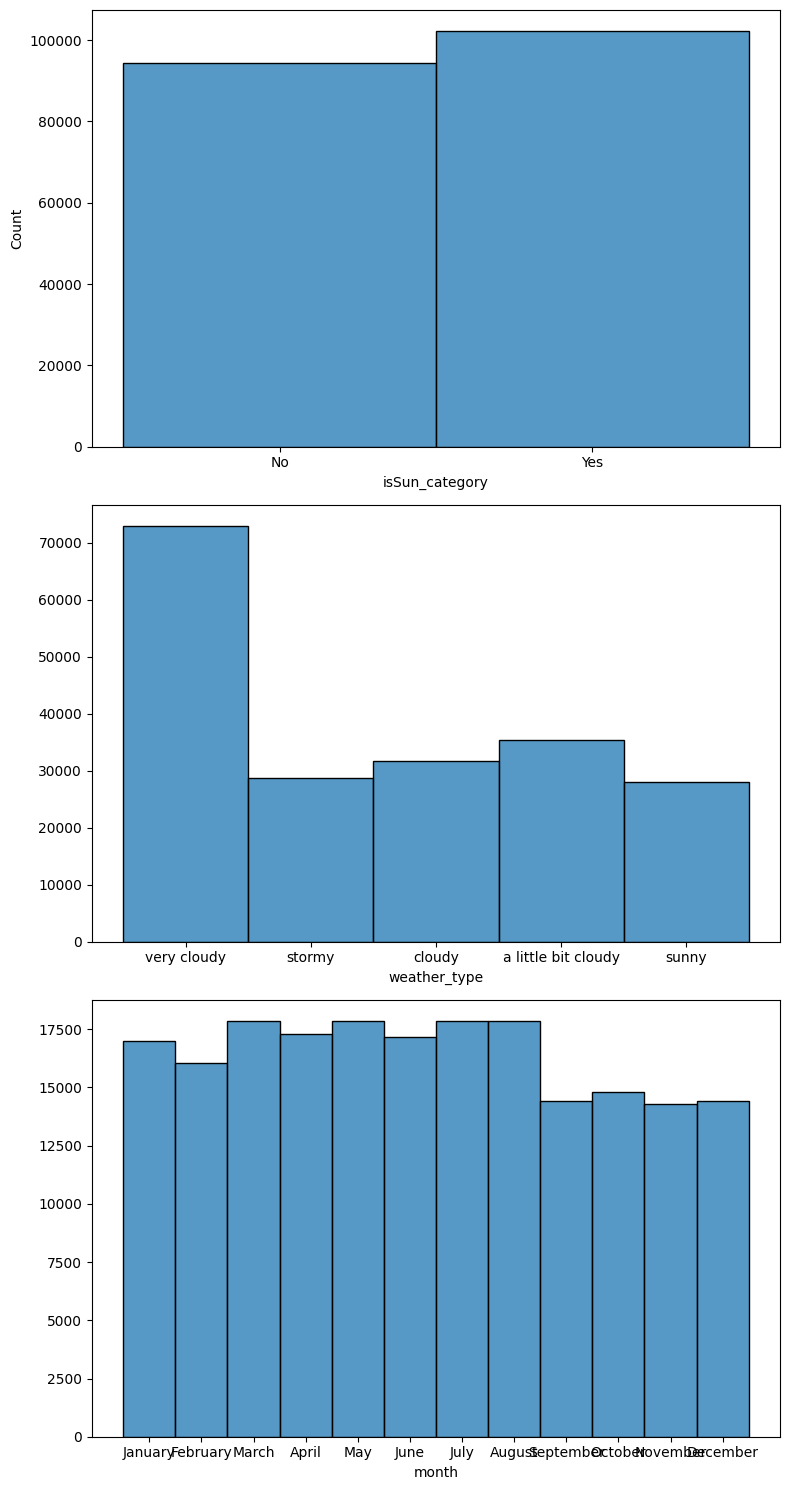

In [18]:
fig, axis = plt.subplots(3, 1, figsize = (8, 15))

# Crear un histograma múltiple
sns.histplot(ax = axis[0], data = total_data, x = "isSun_category")
sns.histplot(ax = axis[1], data = total_data, x = "weather_type").set(ylabel = None)
sns.histplot(ax = axis[2], data = total_data, x = "month").set(ylabel = None)

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

En el tipo de clima en el que se registraron los datos prevalecen ligeramente los días soleados, no obstante también hay una cantidad de días muy nublados ('very cloudy') bastante elevada y diferenciada con respecto a los demás valores de 'weather_type'. Como el registro de datos comienza en 2017-01-01 y termina el 2022-08-31, se observa que los 8 primeros meses contienen mayores registros.

### Análisis de Variables Numéricas ('Time', 'Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'sunlightTime', 'dayLength', 'SunlightTime/daylength')

Previo al análisis de estas variables, hay que transformar la variable 'Time' para su análisis

In [5]:
# diferenciamos bases de datos para mantener la variable 'month' como categórica

total_data_timediv = total_data.copy()

In [6]:
total_data_timediv['Time'] = pd.to_datetime(total_data_timediv['Time'])

# Extraer Año, Mes y Hora
total_data_timediv['year'] = total_data_timediv['Time'].dt.year
total_data_timediv['month'] = total_data_timediv['Time'].dt.month
total_data_timediv['day'] = total_data_timediv['Time'].dt.day
total_data_timediv['hour'] = total_data_timediv['Time'].dt.hour
total_data_timediv['minute'] = total_data_timediv['Time'].dt.minute

total_data.head()

,Time,month,Energy delta[Wh],weather_type,isSun_category,GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,sunlightTime,dayLength,SunlightTime/daylength
0,2017-01-01 00:00:00,January,0,very cloudy,No,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0
1,2017-01-01 00:15:00,January,0,very cloudy,No,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0
2,2017-01-01 00:30:00,January,0,very cloudy,No,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0
3,2017-01-01 00:45:00,January,0,very cloudy,No,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0
4,2017-01-01 01:00:00,January,0,very cloudy,No,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,450,0.0


In [7]:
total_data_timediv = total_data_timediv[['year', 'month', 'day', 'hour', 'minute', 'Energy delta[Wh]', 'weather_type', 'isSun_category',
       'GHI', 'temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h',
       'snow_1h', 'clouds_all', 'sunlightTime', 'dayLength', 'SunlightTime/daylength']].copy()

total_data_timediv.head()

,year,month,day,hour,minute,Energy delta[Wh],weather_type,isSun_category,GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,sunlightTime,dayLength,SunlightTime/daylength
0,2017,1,1,0,0,0,very cloudy,No,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0
1,2017,1,1,0,15,0,very cloudy,No,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0
2,2017,1,1,0,30,0,very cloudy,No,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0
3,2017,1,1,0,45,0,very cloudy,No,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.0
4,2017,1,1,1,0,0,very cloudy,No,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,450,0.0


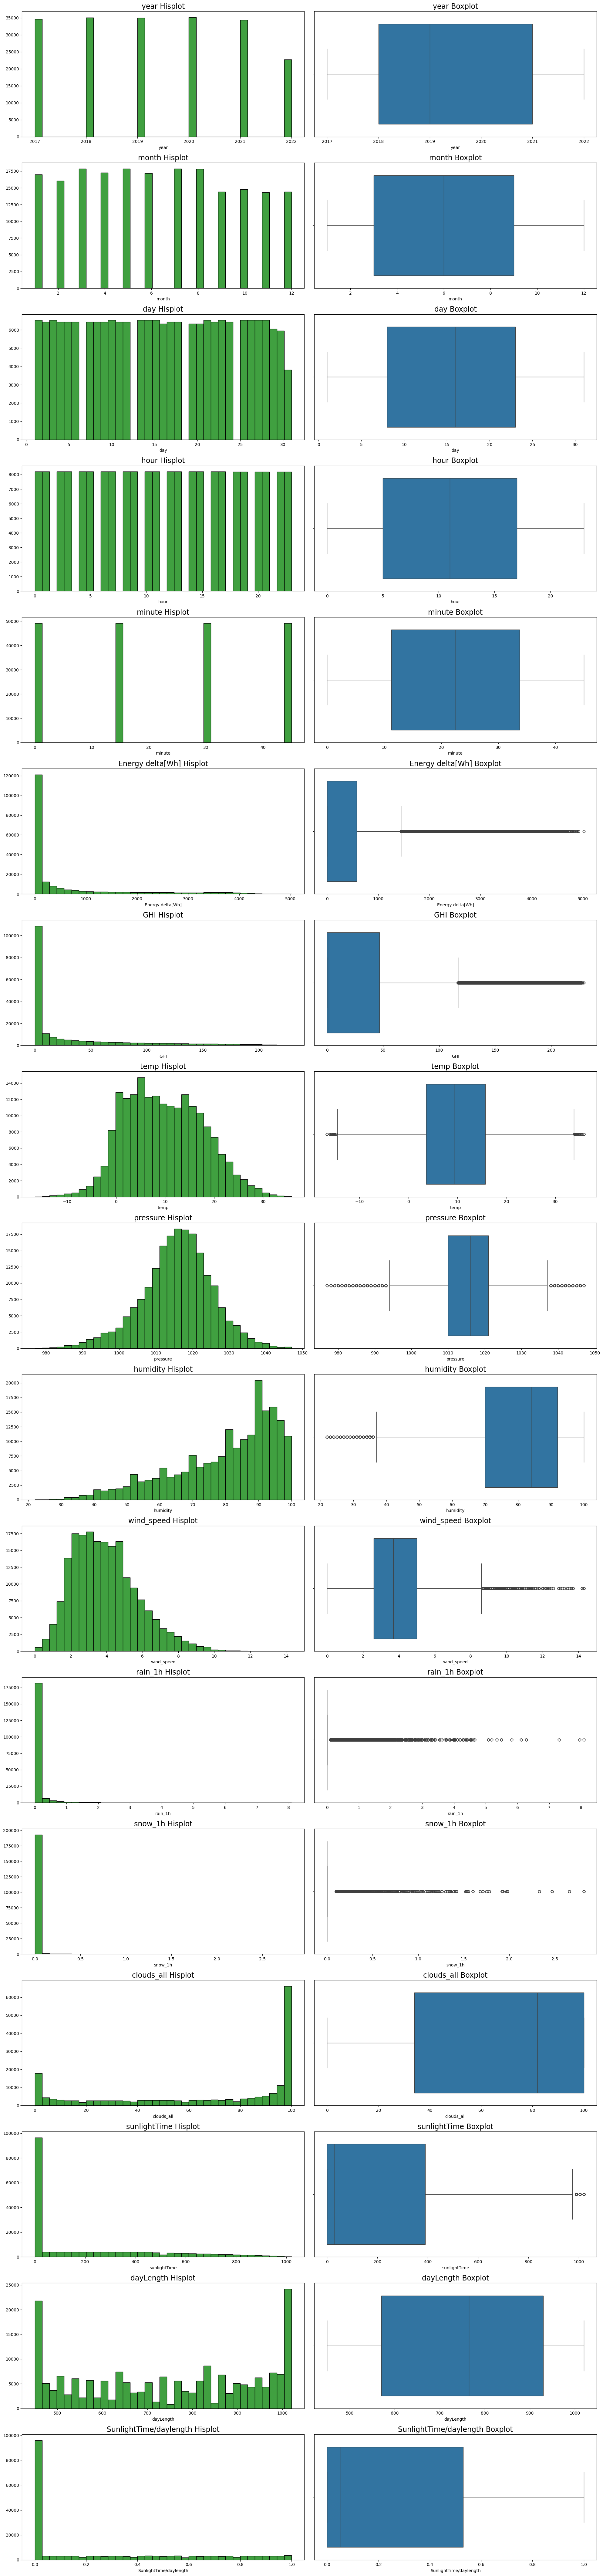

In [22]:
features = ['year', 'month', 'day', 'hour', 'minute', 'Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h',
            'snow_1h', 'clouds_all', 'sunlightTime', 'dayLength', 'SunlightTime/daylength']

# Crear subplots
fig, axes = plt.subplots(len(features), 2, figsize=(20, 5*len(features)))

for i, feature in enumerate(features):

    # Histogram
    sns.histplot(ax=axes[i, 0], data=total_data_timediv, x=feature, bins=35, color='green').set(ylabel=None)
    axes[i, 0].set_title(f'{feature} Hisplot', fontdict={'fontsize': 17})
    
    #boxplot
    sns.boxplot(ax=axes[i, 1], data=total_data_timediv, x=feature)
    axes[i, 1].set_title(f'{feature} Boxplot', fontdict={'fontsize': 17})

plt.tight_layout()
plt.show()

- Year: menor registros de datos en 2022

- Month: número menor de registros en septiembre, octubre, noviembre y diciembre ya que los datos terminan en 2022-08-31.

- Day: se observan menos registros los días 29, 30 y 31 ya que no todos los meses contienen ese número de días.

- Hour/minute: resgitros simétricos y completos.

- Energy Delta (Wh): gran amplitud de registros, pero debido a los registros nocturnos cuando no hay sol, registro = 0 es el de mayor    
  incidencia.

- GHI: gran amplitud de registros, pero debido a los registros nocturnos cuando no hay sol, registro = 0 es el de mayor    
  incidencia.

- temp: la mayor cantidad de registros se observan entre los 1 ºC y 20 ºC, aunque se ven registros extremos tanto por encima como debajo 
  de ese rango.

- pressure: la mayor cantidad de registros se observan entre los 1010 hPa y 1020 hPa, aunque se ven registros tanto por encima 
  como debajo de ese rango.

- humidity: se observa un registro que tiende hacia la derecha, predominando registros con alta humedad y destacando el 90 %.

- wind_speed: se observa un mayor registro de valores entre los 2 km/h y los 5 km/h, habiendo resgitros extremos por encima de este 
  rango, aunque menos predominantes.

- rain_1h: la mayor cantidad de registros se sitúan en los 0 l/m2, es por eso que todo registro poco por encima se considera un valor 
  extremo, aunque en la realidad esos registros extremos observados en el diagrama de caja no sean tan inusuales.
  
- snow_1h: la mayor cantidad de registros se sitúan en los 0 l/m2, es por eso que todo registro poco por encima se considera un valor 
  extremo.

- clouds_all: predominan los registros con un 100 % de nubosidad, aunque en 2º lugar se observan una cantidad alta de nubosidad con % muy bajo en comparación con el resto de 
  registros.

- sunlightTime: debido a los registros de noche, predominan los 0 min de sol, pero a lo largo del día se acumulan los minutos de sol con una tendencia cada vez menor.

- dayLength: se observan mayor cantidad de registros en ambos extremos, destacando la mayor cantidad de días cortos y la mayor cantidad de días largos.

- SunlightTime/daylenth: el registro acaba estando en función de 'sunlightTime', debido a la variación de las horas de sol a lo largo del año.

Se analiza individualmente la variable 'GHI' "sunlightTime", ya que sus datos están sesgados por los registros nocturnos (GHI = 0). Al contrario que las otras variables climáticas, cuyo registro y presencia es o puede ser constante, la irradiación/tiempo solar solo puede ser medido en presencia del sol, es decir, durante las horas de sol. De esta manera, proyectaremos dos diagramas de cajas con los datos de las variables por encima de 0, para poder observar con mayor fidelidad los datos y la presencia de outliers. Filtrando los datos por encima de 0, nos aseguramos que los datos son solamente en presencia del sol.

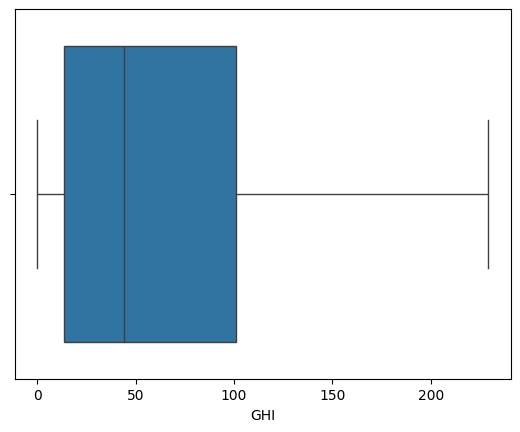

In [23]:
filtered_data = total_data[total_data['GHI'] > 0]


sns.boxplot( data=filtered_data, x= "GHI")
plt.show()

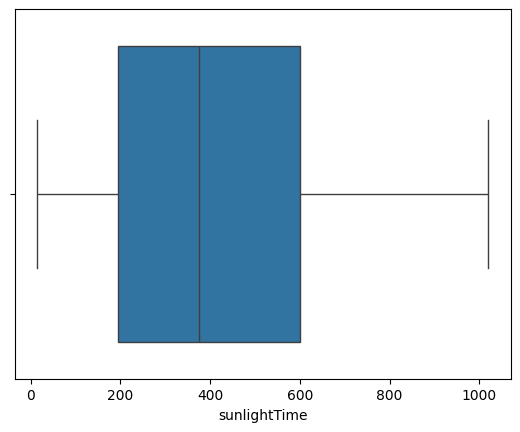

In [24]:
filtered_data = total_data[total_data['sunlightTime'] > 0]


sns.boxplot( data=filtered_data, x= "sunlightTime")
plt.show()

Finalmente se muestran en el diagramas que los datos al parecer no contienen tanta presencia de outliers como aparecía teniendo en cuenta los registros = 0 de la misma. Por lo tanto se concluye que los datos de estas variables no presentan outliers.

# Análisis Multivariante

## Análisis Numérico - Numérico

Analizamos las variables numéricas con las numéricas haciendo de `Energy Delta [Wh]` una comparación con las demas variables para poder sacar conclusiones mas claras acerca de sus relaciones y tomar decisiones sobre su procesamiento

- Relacion entre `Energy Delta [Wh]` / `GHI` y `Energy Delta [Wh]` / `temp`

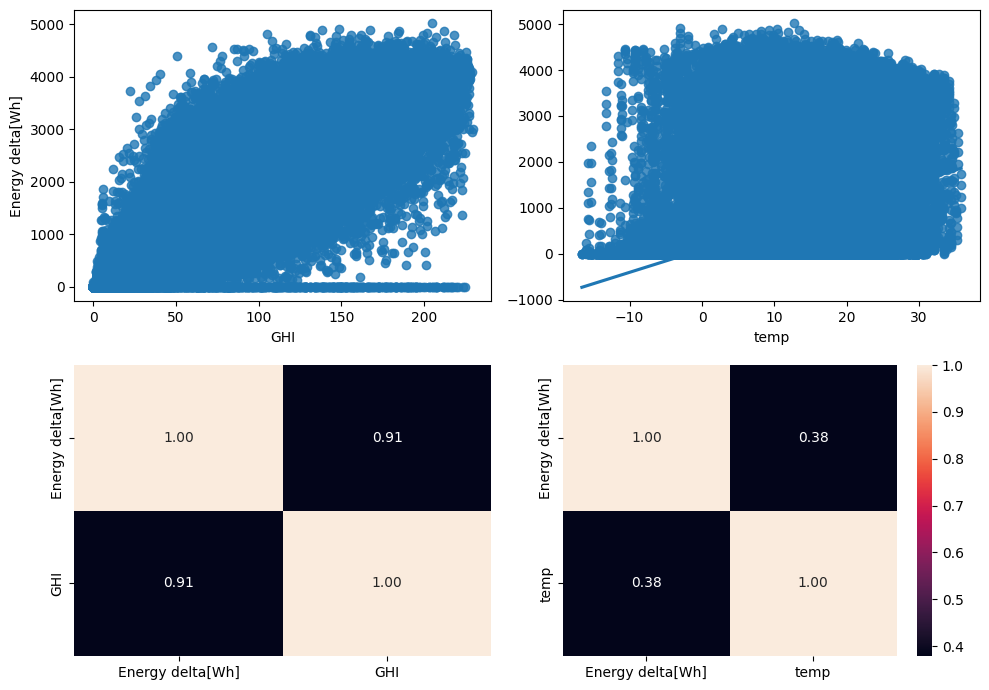

In [25]:
fig, axis = plt.subplots(2, 2, figsize = (10, 7))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0, 0], data = total_data, x = "GHI", y = "Energy delta[Wh]")
sns.heatmap(total_data[["Energy delta[Wh]", "GHI"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = total_data, x = "temp", y = "Energy delta[Wh]").set(ylabel=None)
sns.heatmap(total_data[["Energy delta[Wh]", "temp"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

Existe una relación muy directa entre la irradiación global horizontal y el consumo de energía. Así también, se puede observar que la relación entre la energía de consumo y la temperatura, tienen una relacion directa (pero no tan fuerte) debido a que la temperatura tiene importancia sobre la predictora pero no se ve tan reflejada como la anterior.

- Relacion entre `Energy Delta [Wh]` / `month` y `Energy Delta [Wh]` / `hour`

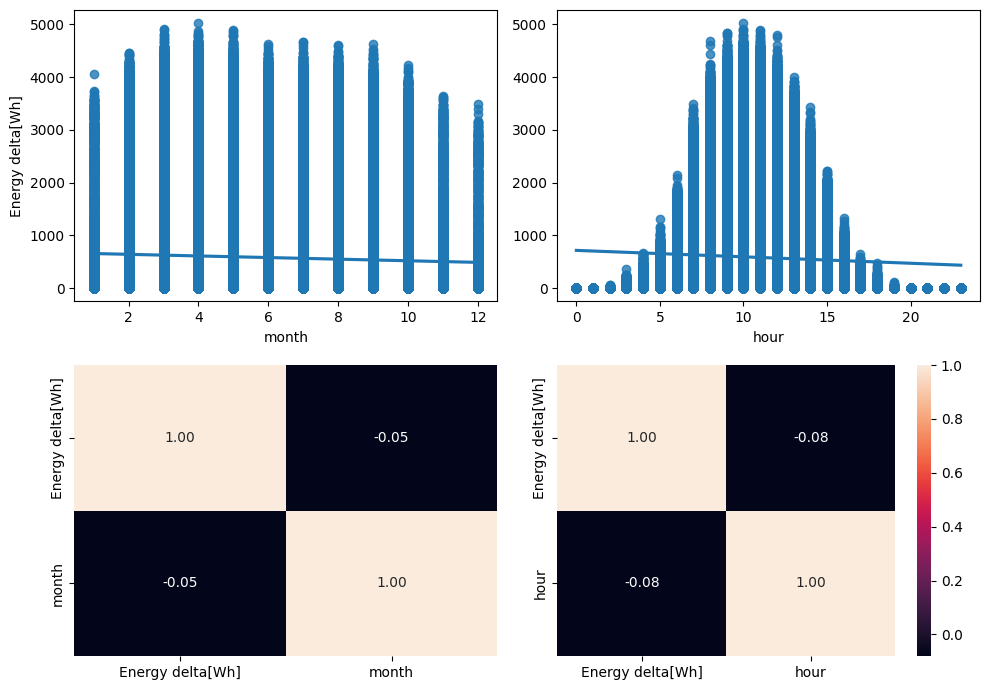

In [26]:
fig, axis = plt.subplots(2, 2, figsize = (10, 7))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0, 0], data = total_data_timediv, x = "month", y = "Energy delta[Wh]")
sns.heatmap(total_data_timediv[["Energy delta[Wh]", "month"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = total_data_timediv, x = "hour", y = "Energy delta[Wh]").set(ylabel=None)
sns.heatmap(total_data_timediv[["Energy delta[Wh]", "hour"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

En la relacion con los meses se observa una forma de manera ascendente desde enero hasta abril que es donde encontramos el pico mas alto, y una forma descendente desde mayo hasta febrero. En comparación con las horas, se ve que se recoge más energía en las horas de sol, que se ubican a partir de las 7 teniendo su pico a las 10 de la mañana y decreciendo a lo largo del día.

- Relacion entre `Energy Delta [Wh]` / `pressure` y `Energy Delta [Wh]` / `humidity`

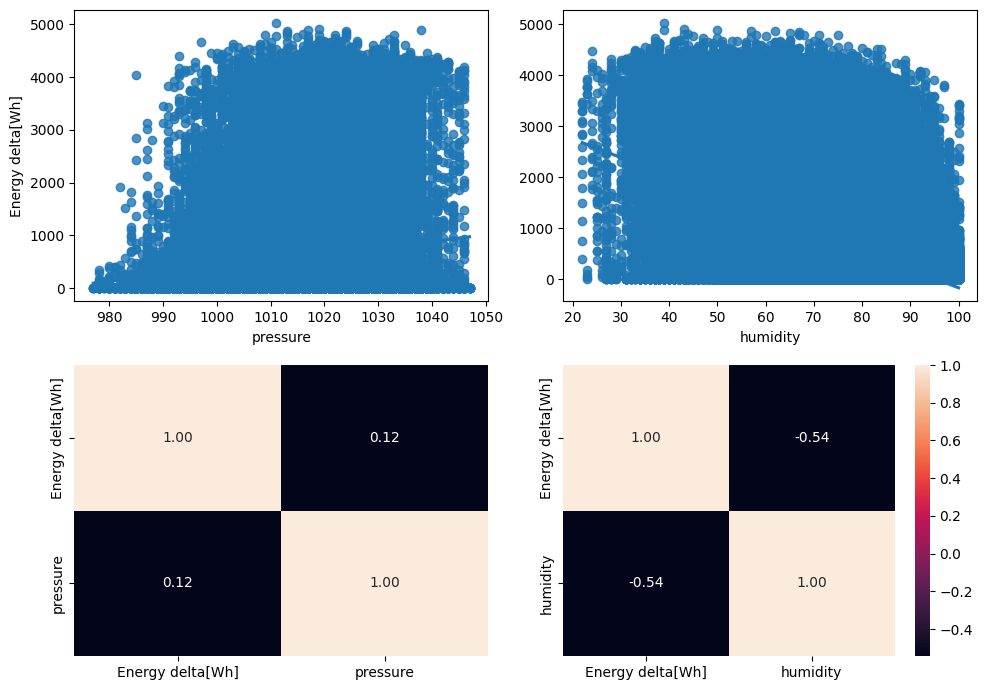

In [27]:
fig, axis = plt.subplots(2, 2, figsize = (10, 7))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0, 0], data = total_data, x = "pressure", y = "Energy delta[Wh]")
sns.heatmap(total_data[["Energy delta[Wh]", "pressure"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = total_data, x = "humidity", y = "Energy delta[Wh]").set(ylabel=None)
sns.heatmap(total_data[["Energy delta[Wh]", "humidity"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

La correlación entre la presion y la energía es muy débil, lo que sugiere que la presión no tiene un impacto significativo en el cambio de energía. Entre la humedad y la Energía hay una correlación negativa moderada, sugiriendo que la humedad influye más notablemente en la energía, con un aumento en la humedad generalmente asociado a una disminución en la energía.

- Relacion entre `Energy Delta [Wh]` / `wind_speed` y `Energy Delta [Wh]` / `rain_1h`

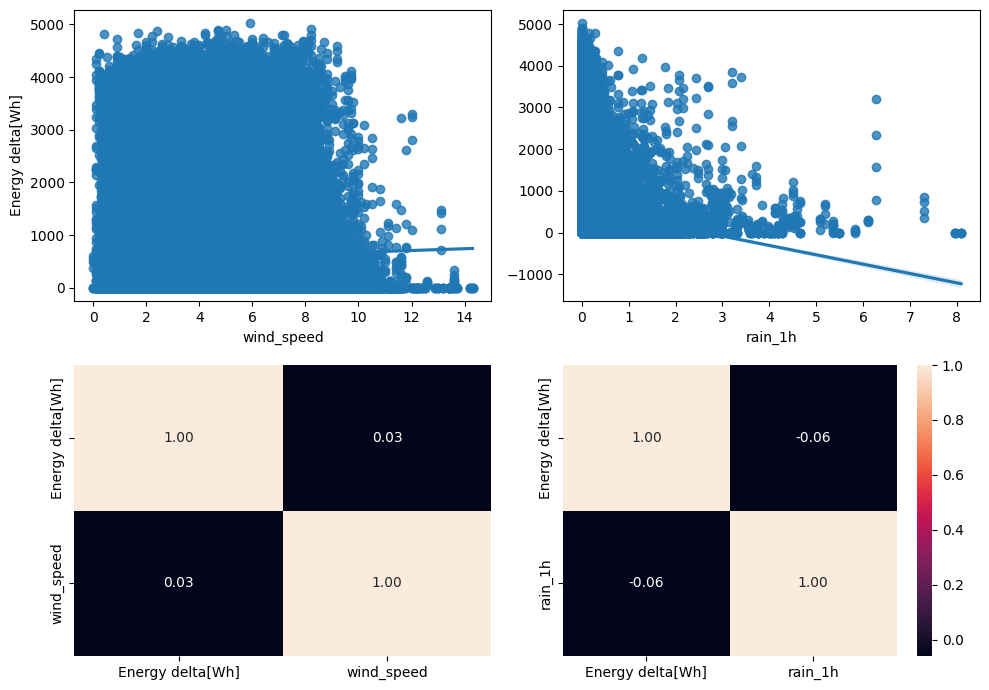

In [28]:
fig, axis = plt.subplots(2, 2, figsize = (10, 7))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0, 0], data = total_data, x = "wind_speed", y = "Energy delta[Wh]")
sns.heatmap(total_data[["Energy delta[Wh]", "wind_speed"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = total_data, x = "rain_1h", y = "Energy delta[Wh]").set(ylabel=None)
sns.heatmap(total_data[["Energy delta[Wh]", "rain_1h"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

La velocidad del viento y la energia tienen una correlación que es muy débil, sugiriendo que la velocidad del viento no tiene un impacto significativo en la energía. Con la lluvia pasa exactamente igual, aunque la correlación es débil, hay una tendencia negativa observable, indicando que un aumento en la lluvia podría estar asociado con una disminución en la energía.

- Relacion entre `Energy Delta [Wh]` / `snow_1h` y `Energy Delta [Wh]` / `clouds_all`

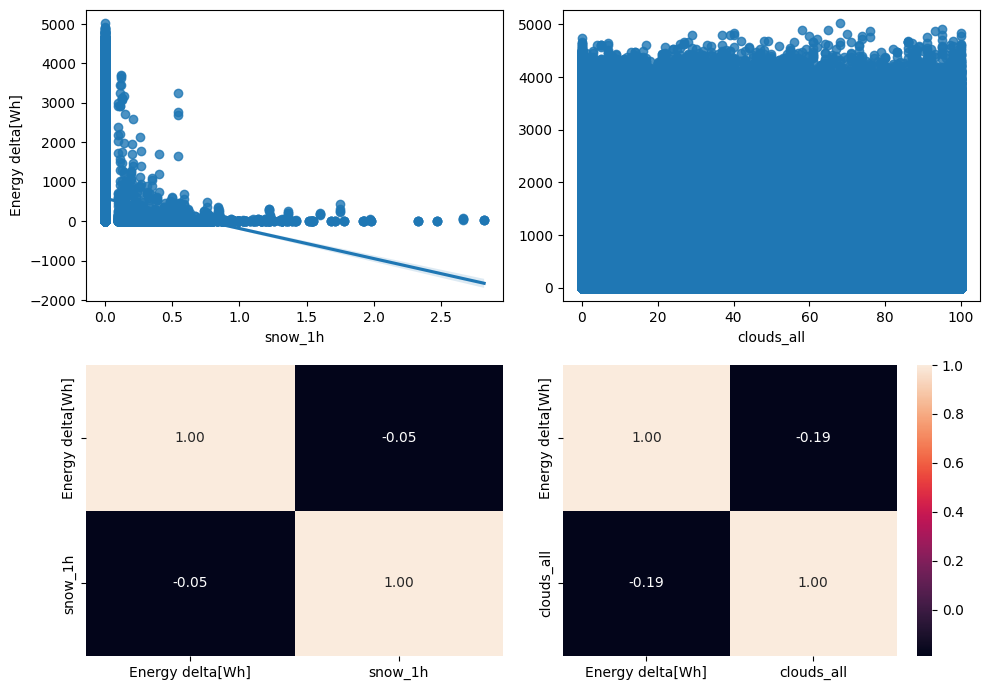

In [29]:
fig, axis = plt.subplots(2, 2, figsize = (10, 7))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0, 0], data = total_data, x = "snow_1h", y = "Energy delta[Wh]")
sns.heatmap(total_data[["Energy delta[Wh]", "snow_1h"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = total_data, x = "clouds_all", y = "Energy delta[Wh]").set(ylabel=None)
sns.heatmap(total_data[["Energy delta[Wh]", "clouds_all"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

Entre la nieve en 1 Hora y la energía, la correlación es muy débil, sugiriendo que la cantidad de nieve tiene un impacto mínimo en la energía. En cuanto a la nubosidad y la energía, hay una correlación negativa débil, indicando que un aumento en la nubosidad podría estar asociado con una ligera disminución de la energía, aunque la relación no es fuerte.

- Relacion entre `Energy Delta [Wh]` / `sunlightTime` y `Energy Delta [Wh]` / `dayLength`

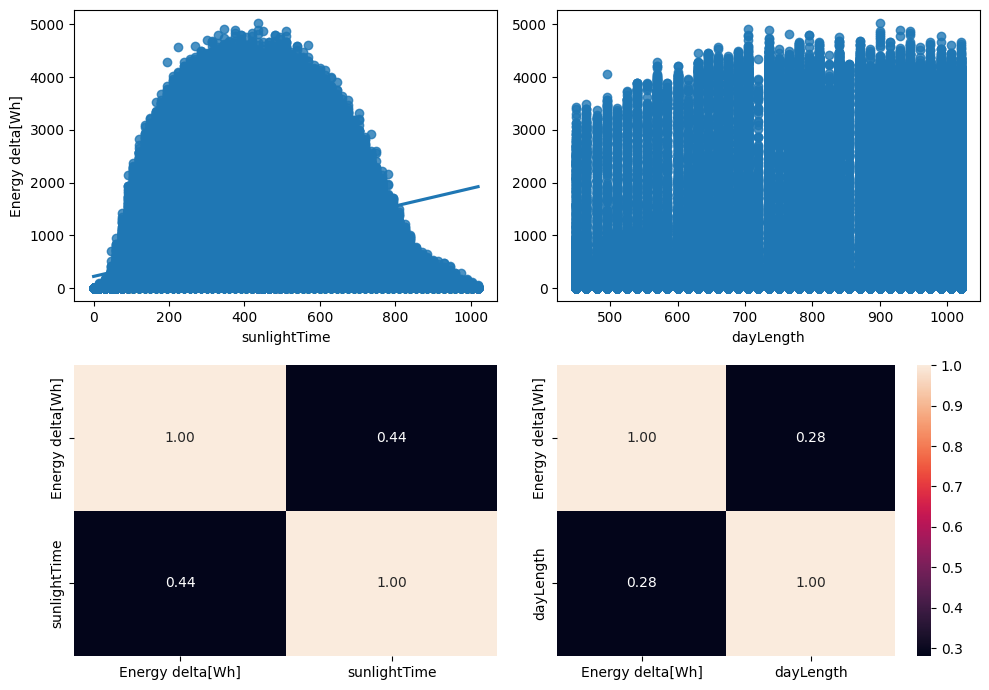

In [30]:
fig, axis = plt.subplots(2, 2, figsize = (10, 7))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0, 0], data = total_data, x = "sunlightTime", y = "Energy delta[Wh]")
sns.heatmap(total_data[["Energy delta[Wh]", "sunlightTime"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = total_data, x = "dayLength", y = "Energy delta[Wh]").set(ylabel=None)
sns.heatmap(total_data[["Energy delta[Wh]", "dayLength"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

Se observa una relacion considerable entre la duración de tiempo de sol y de energía ya que a mas horas de sol mayor energía se recoge. En cambio se observa una relacion menos fuerte con la energía y lo largo del día ya que hay franjas horarias en las que se recoge más y en otras disminuye.

## Análisis Categórico-Categórico

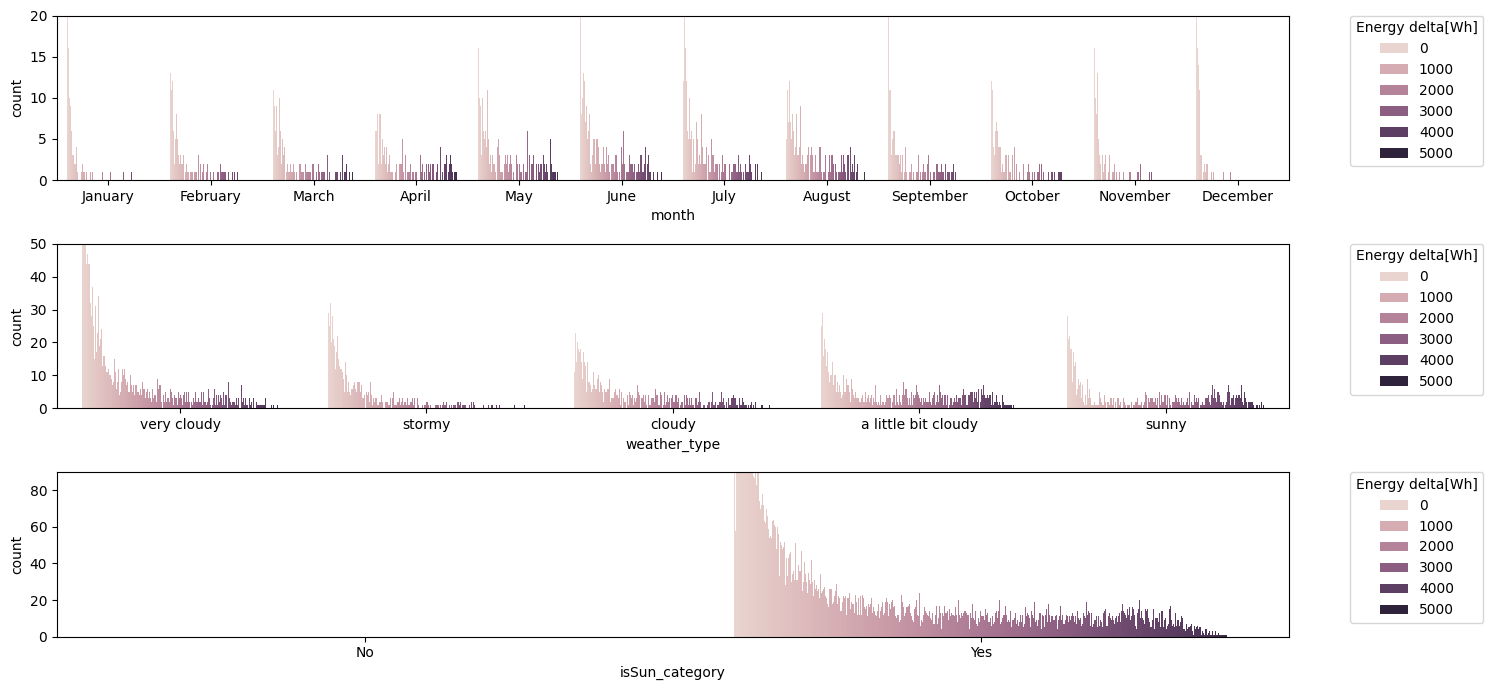

In [31]:
# se establece un límite para el eje y, de manera que sea posible visualizar corectamente los gráficos

fig, axis = plt.subplots(3, figsize=(15, 7))

# Primer gráfico
sns.countplot(ax=axis[0], data=total_data, x="month", hue="Energy delta[Wh]").set(ylim=(0, 20))
legend_0 = axis[0].legend(title="Energy delta[Wh]", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Segundo gráfico
sns.countplot(ax=axis[1], data=total_data, x="weather_type", hue="Energy delta[Wh]").set(ylim=(0, 50))
legend_1 = axis[1].legend(title="Energy delta[Wh]", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Tercer gráfico
sns.countplot(ax=axis[2], data=total_data, x="isSun_category", hue="Energy delta[Wh]").set(ylim=(0, 90))
legend_2 = axis[2].legend(title="Energy delta[Wh]", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

* month-Energy delta[Wh]: los registros más altos se encuentran en los meses de abril, mayo, junio, julio, agosto y septiembre. Resalta en todos los meses que los registros más numerosos son los cercanos a 0, influenciado claramente por los registros nocturnos.

* weather_type-Energy delta[Wh]: se puede observar que los tipos de climas más asociados a nubosidad o lluvias tienen mayor cantidad de datos asociados a registros bajos de Wh proveniente de la variable "Energy Delta[Wh]".

* isSun_category-Energy delta[Wh]: como era de esperar todos los datos asociados de la variable "Energy delta[Wh]" se encuentran en la vategoría "Yes" de la variable "isSun_category". Esto es debido que los datos de "Energy delta[Wh]" solo tienen lugar cuando hay presencia solar.

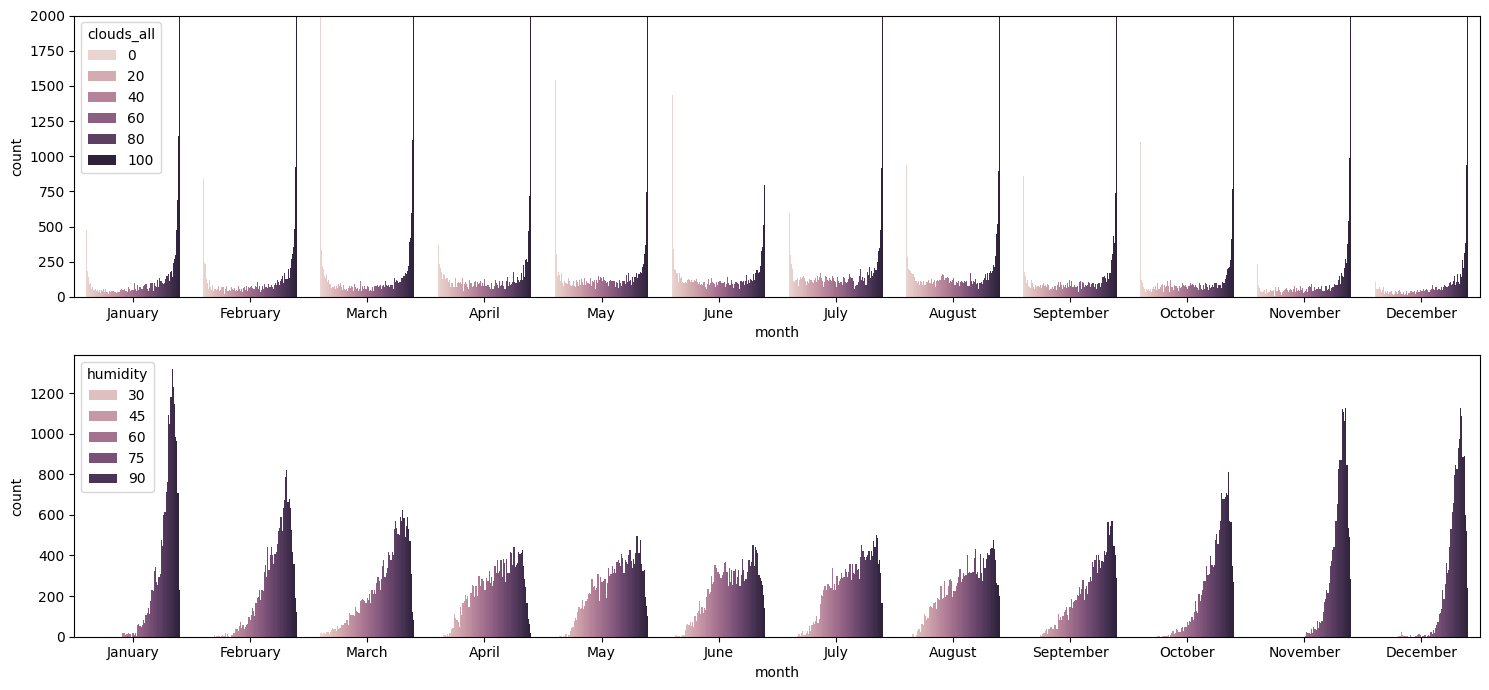

In [32]:
fig, axis = plt.subplots(2, figsize=(15, 7))


sns.countplot(ax = axis[0], data=total_data, x="month", hue="clouds_all").set(ylim=(0, 2000))
sns.countplot(ax = axis[1], data = total_data, x = "month", hue = "humidity")

plt.tight_layout()
plt.show()


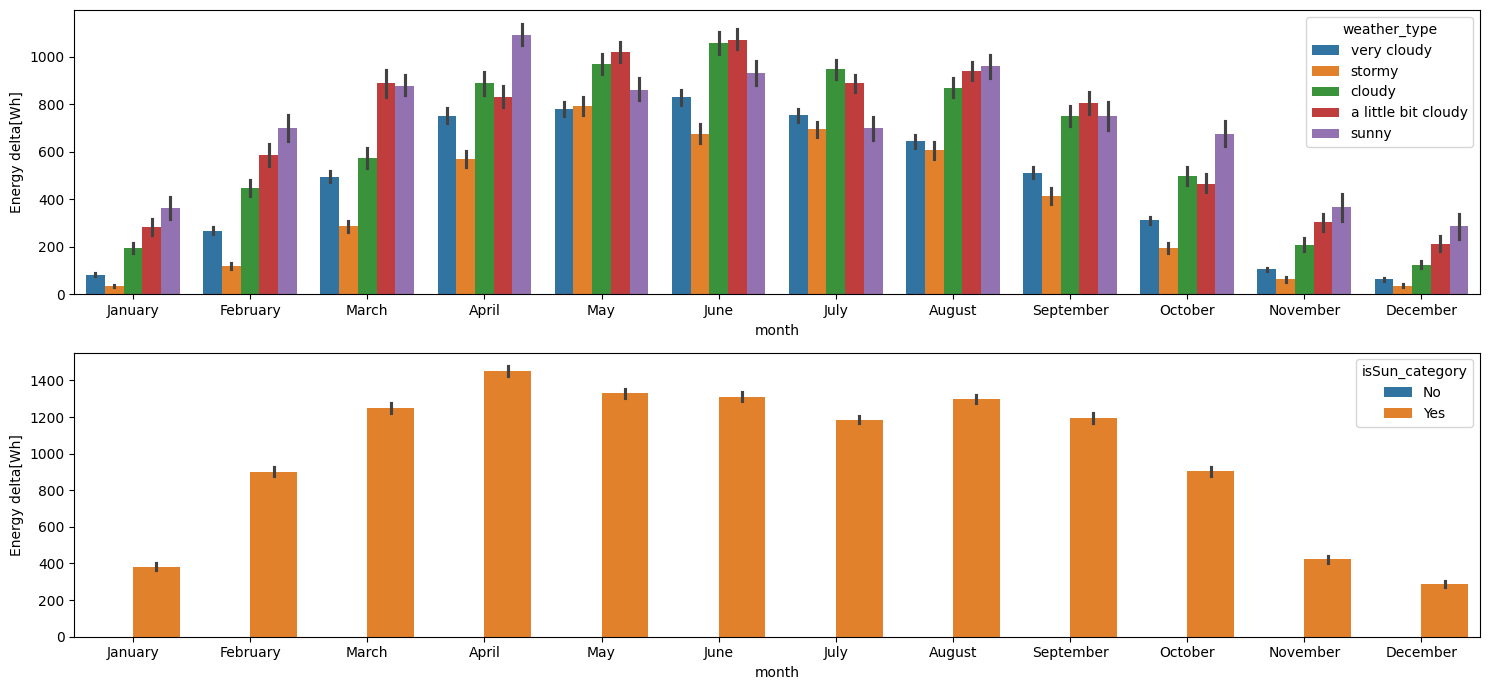

In [33]:
fig, axis = plt.subplots(2, figsize=(15, 7))

sns.barplot(ax = axis[0], data = total_data, x = "month", y = "Energy delta[Wh]", hue = "weather_type")
sns.barplot(ax = axis[1], data = total_data, x = "month", y = "Energy delta[Wh]", hue = "isSun_category")

plt.tight_layout()

plt.show()

En estos gráficos observamos cómo aún estando presentes durante todos los meses del año los 5 tipos de clima, en los meses de abril, mayo, junio, julio, agosto y septiembre son dónde más hay registros de datos altos de "Energy delta[Wh]".

## Análisis Numérico-Categórico

##### Análisis de correlaciones

El análisis multivariante también permite combinar la clase con varias predictoras al mismo tiempo para enriquecer el análisis. Este tipo de operaciones deben ser subjetivas y deben combinar características relacionadas entre sí.

In [34]:
# Paso 1: Identificar columnas categóricas
columnas_categoricas = total_data_timediv.select_dtypes(include=['object']).columns
columnas_categoricas

Index(['weather_type', 'isSun_category'], dtype='object')

In [8]:
#factorize
total_data_timediv["weather_type_n"] = pd.factorize(total_data_timediv["weather_type"])[0]
total_data_timediv["isSun_n"] = pd.factorize(total_data_timediv["isSun_category"])[0]

total_data_timediv.head(10)

,year,month,day,hour,minute,Energy delta[Wh],weather_type,isSun_category,GHI,temp,...,humidity,wind_speed,rain_1h,snow_1h,clouds_all,sunlightTime,dayLength,SunlightTime/daylength,weather_type_n,isSun_n
0,2017,1,1,0,0,0,very cloudy,No,0.0,1.6,...,100,4.9,0.0,0.0,100,0,450,0.0,0,0
1,2017,1,1,0,15,0,very cloudy,No,0.0,1.6,...,100,4.9,0.0,0.0,100,0,450,0.0,0,0
2,2017,1,1,0,30,0,very cloudy,No,0.0,1.6,...,100,4.9,0.0,0.0,100,0,450,0.0,0,0
3,2017,1,1,0,45,0,very cloudy,No,0.0,1.6,...,100,4.9,0.0,0.0,100,0,450,0.0,0,0
4,2017,1,1,1,0,0,very cloudy,No,0.0,1.7,...,100,5.2,0.0,0.0,100,0,450,0.0,0,0
5,2017,1,1,1,15,0,very cloudy,No,0.0,1.7,...,100,5.2,0.0,0.0,100,0,450,0.0,0,0
6,2017,1,1,1,30,0,very cloudy,No,0.0,1.7,...,100,5.2,0.0,0.0,100,0,450,0.0,0,0
7,2017,1,1,1,45,0,very cloudy,No,0.0,1.7,...,100,5.2,0.0,0.0,100,0,450,0.0,0,0
8,2017,1,1,2,0,0,very cloudy,No,0.0,1.9,...,100,5.5,0.0,0.0,100,0,450,0.0,0,0
9,2017,1,1,2,15,0,very cloudy,No,0.0,1.9,...,100,5.5,0.0,0.0,100,0,450,0.0,0,0


In [36]:
total_data_timediv[["weather_type", "weather_type_n"]].to_excel("/workspaces/Final-Project-JOF/data/processed/diccionario_weather_type.xlsx", index = False)
total_data_timediv[["isSun_category", "isSun_n"]].to_excel("/workspaces/Final-Project-JOF/data/processed/diccionario_isSun.xlsx", index = False)

In [37]:
total_data_timediv.columns

Index(['year', 'month', 'day', 'hour', 'minute', 'Energy delta[Wh]',
       'weather_type', 'isSun_category', 'GHI', 'temp', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'sunlightTime',
       'dayLength', 'SunlightTime/daylength', 'weather_type_n', 'isSun_n'],
      dtype='object')

In [9]:
columnas=[ 'year', 'month', 'day', 'hour', 'minute',
       'Energy delta[Wh]',   'GHI', 'temp',
       'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_1h',
       'clouds_all', 'sunlightTime', 'dayLength', 'SunlightTime/daylength',
       'weather_type_n', 'isSun_n']
    # Crear DataFrame df2 con las columnas seleccionadas
total_final_data = total_data_timediv[columnas]

# Verificar el resultado
total_final_data

,year,month,day,hour,minute,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,sunlightTime,dayLength,SunlightTime/daylength,weather_type_n,isSun_n
0,2017,1,1,0,0,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.00,0,0
1,2017,1,1,0,15,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.00,0,0
2,2017,1,1,0,30,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.00,0,0
3,2017,1,1,0,45,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,450,0.00,0,0
4,2017,1,1,1,0,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,450,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196771,2022,8,31,16,45,118,23.7,18.6,1023,57,3.8,0.0,0.0,52,780,825,0.95,2,1
196772,2022,8,31,17,0,82,15.6,18.5,1023,61,4.2,0.0,0.0,60,795,825,0.96,2,1
196773,2022,8,31,17,15,51,8.0,18.5,1023,61,4.2,0.0,0.0,60,810,825,0.98,2,1
196774,2022,8,31,17,30,24,2.1,18.5,1023,61,4.2,0.0,0.0,60,825,825,1.00,2,1


In [39]:
total_final_data.to_csv("/workspaces/Final-Project-JOF/data/processed/total_final_data.csv")

**<span style="color:#004080;">Todas columnas son Numericas</span>**

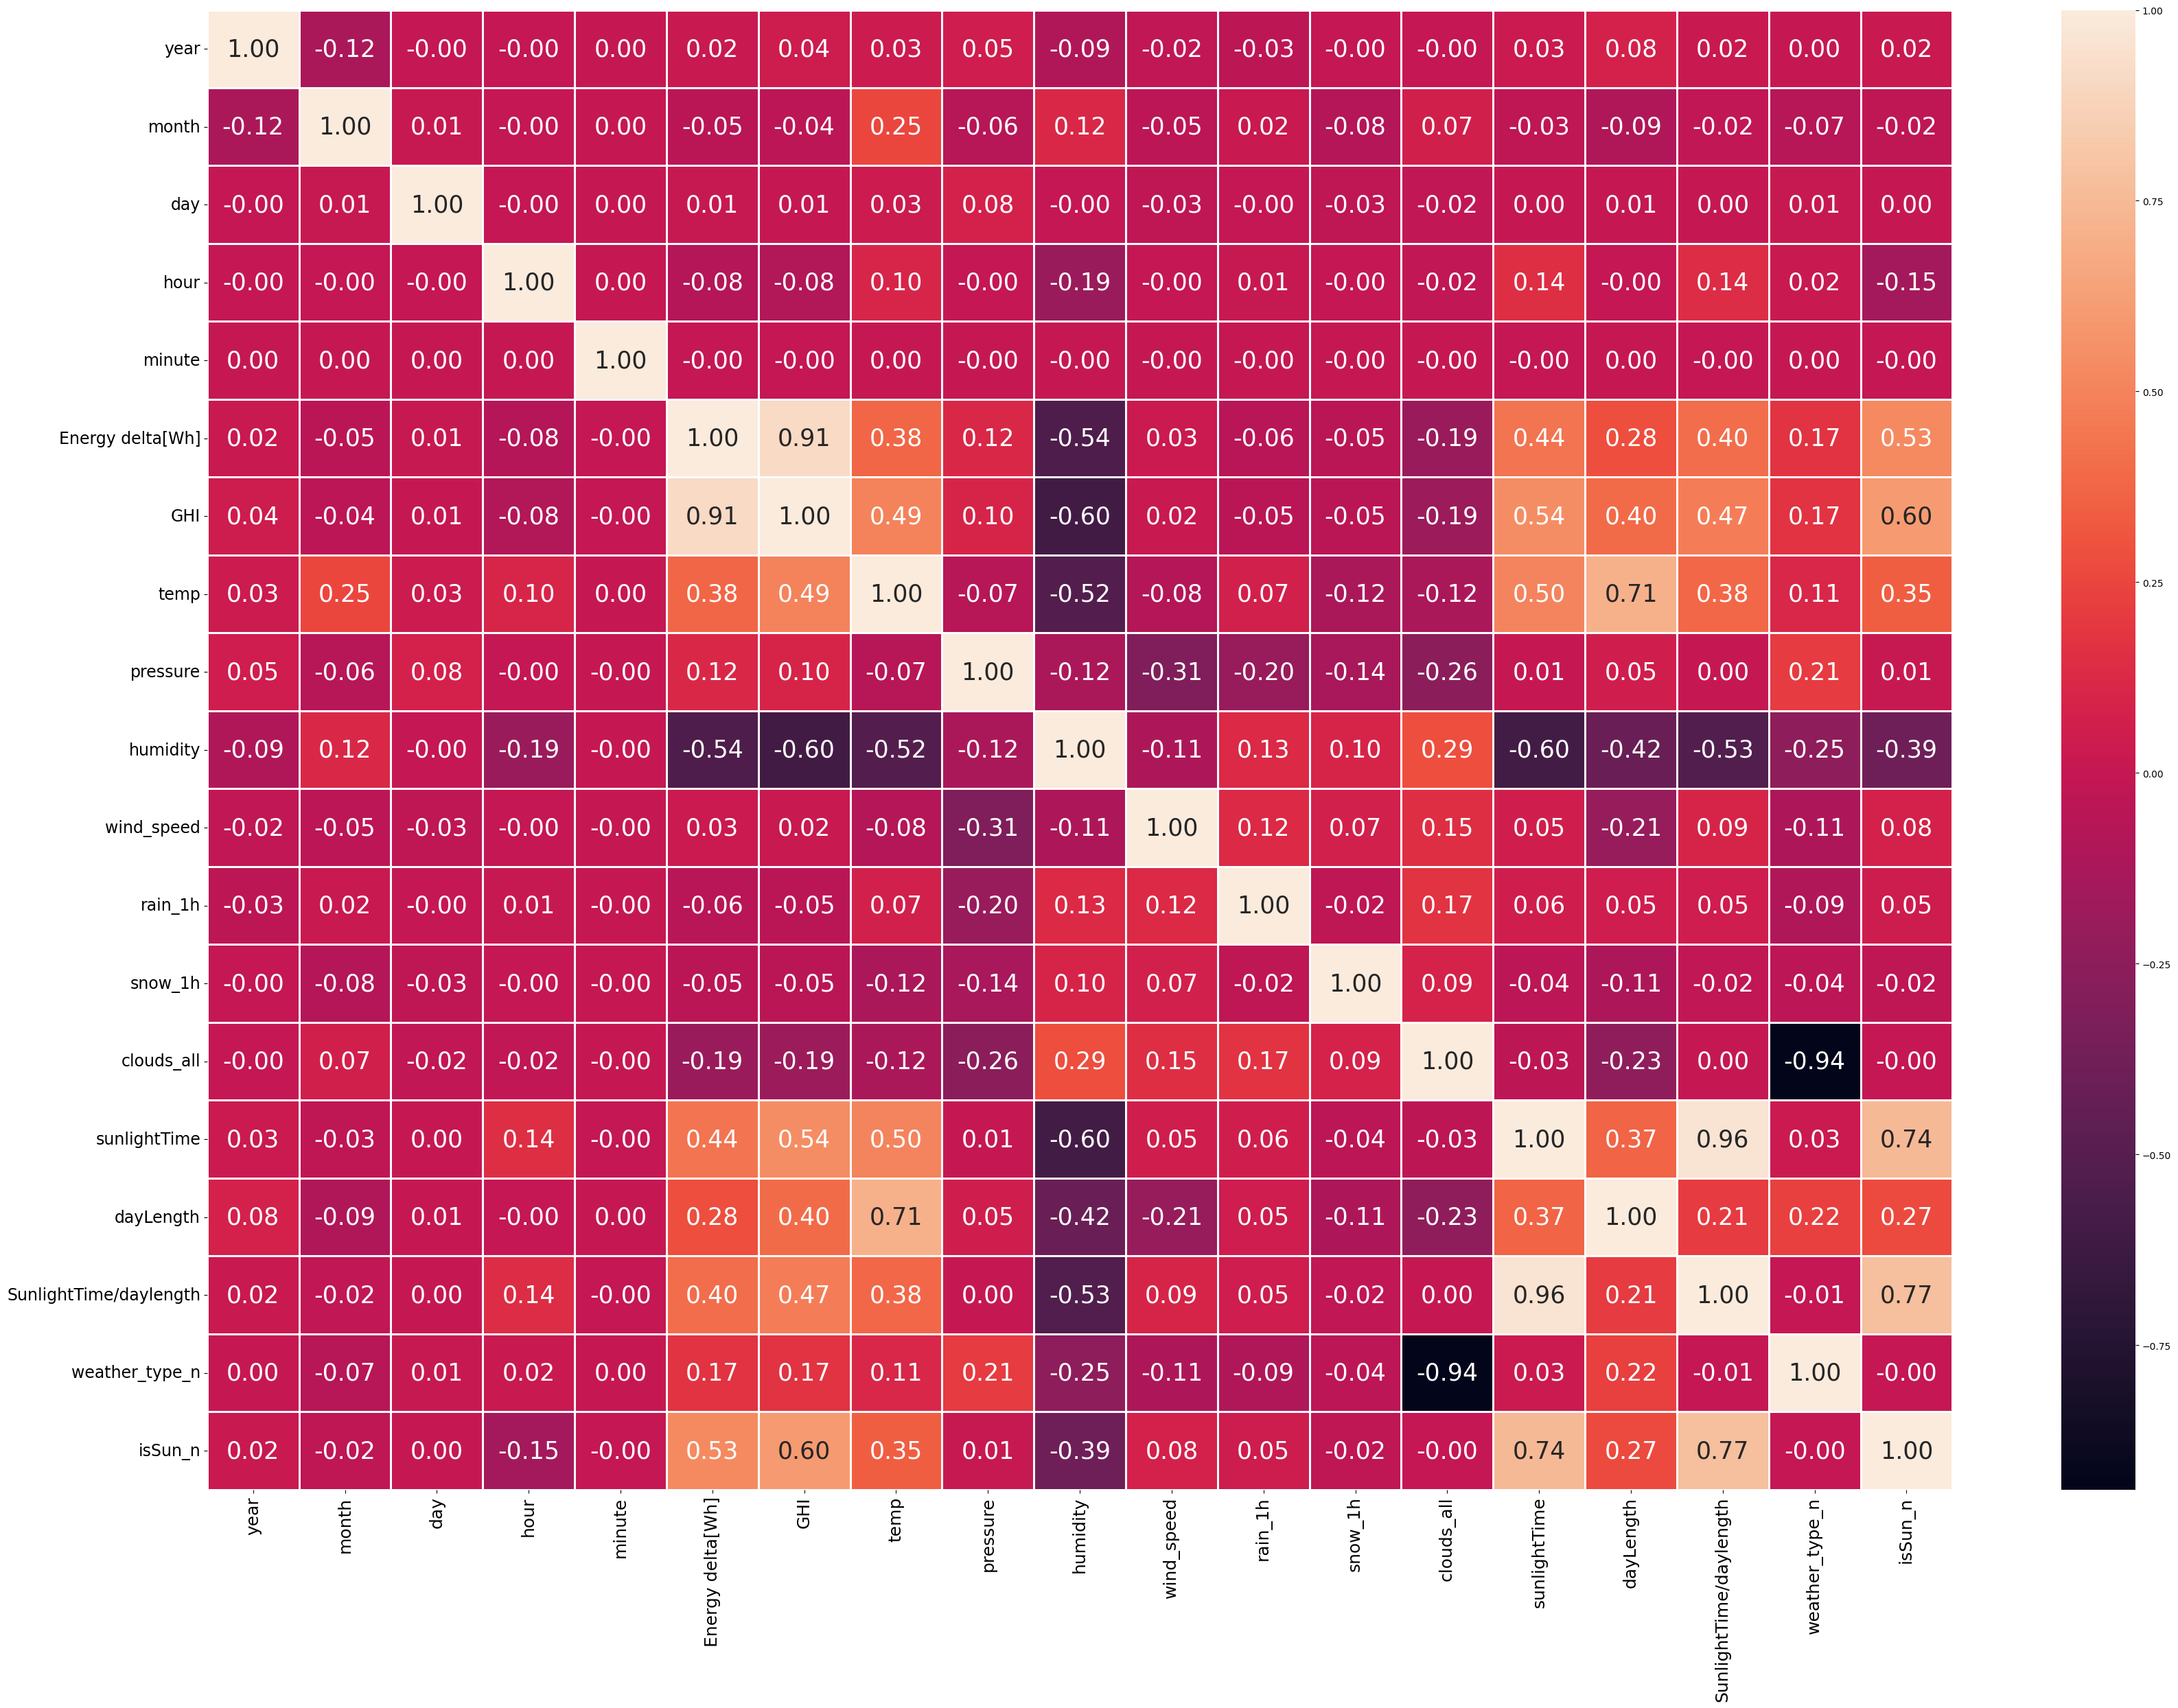

In [40]:
#correlacion

import matplotlib.pyplot as plt 
correlation_matrix = total_final_data.corr()

# Visualizar la matriz de correlación usando un heatmap
fig, axis = plt.subplots(figsize=(35,25))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linecolor='white', linewidths=1, annot_kws={"size": 25})
plt.xticks(fontsize=18)
plt.yticks(fontsize=17)
plt.tight_layout()
plt.show()

**There are some  relation between**
- **Month-temp(0.25)** Indica una relación positiva débil. La temperatura tiende a aumentar o disminuir con el cambio de mes, pero hay una gran variabilidad debido a otros factores.


**MINUTE - no tiene ninguna corelacion con variables, a alo lagropodemos eliminar la**

**There are some  relation between**
- **Hour-sunlighttIME/Daylenth(0.14)**
Una correlación de 0.14 entre la hora y la duración de la luz solar o la duración del día indica una relación positiva débil. Esto sugiere que hay una ligera tendencia a que la duración de la luz solar esté relacionada con la hora del día, pero la relación no es muy fuerte.

**There are strong negative relation between**
- **Energy delta-humidity(-0.54)**
    **Descripción: A medida que la humedad aumenta, la variabilidad en la energía (delta de energía) tiende a disminuir.**
    **Explicación:**
    **En condiciones de alta humedad, es probable que haya más nubosidad y menor radiación solar directa, lo que reduce la eficiencia de la producción de energía solar.**
- **GHI-humidity(-0.60)**
     **Descripción: A medida que la humedad aumenta, la irradiancia horizontal global (cantidad de radiación solar recibida en una superficie horizontal) disminuye.**
    **Explicación:**
    **Alta humedad está asociada con mayor nubosidad. Las nubes y el vapor de agua en la atmósfera dispersan y absorben la luz solar, reduciendo la cantidad de radiación solar que llega a la superficie terrestre.**
- **Temp-humidity(-0.52)**
    **Descripción: A medida que la humedad aumenta, la temperatura tiende a disminuir.**
      **Explicación:**
    **En climas húmedos, la evaporación y la presencia de nubes pueden tener un efecto refrescante durante el día.**
- **Pressure-humidity(-0.12)**
    **Descripción: A medida que la humedad aumenta, la presión tiende a disminuir, aunque la relación es débil.**
    **Explicación:**
    **Alta humedad está frecuentemente asociada con sistemas de baja presión, como frentes fríos o tormentas.**

- **SunlightTime/daylenght-humidity(-0.53)**
- **SunlightTime-humidity(-0.60)**
- **IsSun_n-humidity(-0.30)**
    **Descripción: A medida que la cantidad de tiempo con luz solar directa aumenta, la humedad tiende a disminuir.**
    **Explicación:**
    **Mayor cantidad de luz solar directa está asociada con condiciones menos nubladas y más secas, lo que reduce la humedad relativa.**

- **day Lenghht-humidity(-0.42)**
   **Descripción: A medida que la longitud del día aumenta, la humedad tiende a disminuir.**
   **Explicación:**
   **En épocas del año con días más largos (como el verano), las temperaturas suelen ser más altas, lo que reduce la humedad relativa debido a la mayor capacidad del aire caliente para retener vapor **agua.**

- **Where_type-humidity(-0.25)**
    **Una correlación de -0.25 entre Weather_type y la humedad indica una relación negativa débil. Esto significa que ciertos tipos de lugares tienden a tener diferentes niveles de humedad, y a medida que cambiamos de un tipo de lugar a otro, la humedad puede variar de manera sistemática, aunque la relación no es muy fuerte.**
   
 - **Hour-humidity(-0.19)** 
    **Una correlación de -0.19 entre la hora y la humedad indica una relación negativa débil. Esto significa que a medida que avanza el día, la humedad tiende a disminuir ligeramente, pero no de manera muy fuerte** 

- **Month-humidity(0.12)** Indica una relación muy débil. La humedad no muestra un patrón claro de cambio con el mes, sugiriendo que otros factores son más influyentes.
**En resumen, la relación entre el mes y la temperatura refleja las variaciones estacionales que son típicas en muchos climas, aunque no de manera muy fuerte. La relación entre el mes y la humedad es más débil porque la humedad depende de muchos otros factores además de los cambios estacionales.** 


**Resumen General:** 
**Las relaciones indican que a medida que la humedad aumenta, disminuyen parámetros como la variabilidad energética, irradiancia solar, temperatura y tiempo de luz solar directa. La humedad está asociada con condiciones más nubladas, menos eficientes para la energía solar y más frescas. La longitud del día y el tipo de lugar también afectan la humedad, aunque con una relación más débil.** 

**There are strong Positive  relation between**
- **Ghi-Energy(0,91)**
    Descripción: A mayor irradiancia horizontal global, mayor producción de energía.
- **Temp-Energy(0,38)**
    Descripción: A mayor temperatura, mayor producción de energía.
- **Whether_type-Energy(0,38)**
    El tipo de lugar influye en la disponibilidad de radiación solar y condiciones ambientales. Por ejemplo, áreas desérticas o zonas con alta exposición solar generalmente producen más energía solar.

- **DayLenght-Energy(0,28)**
    Descripción: A mayor longitud del día, mayor producción de energía.
- **Sunlight-Energy(0,44)**
    Descripción: A mayor cantidad de luz solar, mayor producción de energía
- **SunLight/daylenght-Energy(0,40)**
    A mayor combinación de luz solar y duración del día, mayor producción de energía.
- **isSun-Energy(0,53)**
    La presencia de sol aumenta la producción de energía. 

**<span style="color:#004080;">Resumen General"</span>**
**<span style="color:#004080;">Las relaciones positivas fuertes indican que la producción de energía está fuertemente influenciada por la irradiancia solar, la temperatura, el tipo de lugar, la duración del día y la cantidad de luz solar. Estos factores son críticos para la eficiencia y la cantidad de energía generada, especialmente en sistemas solares fotovoltaicos. En general, las condiciones que aumentan la disponibilidad de radiación solar y las horas de luz del día tienden a aumentar significativamente la producción de energía."</span>**

**<span style="color:#004080;">GHI significa "Global Horizontal Irradiance"</span>**

**<span style="color:#004080;">Global Horizontal Irradiance" en inglés, que se traduce al español como "Irradiancia Global Horizontal". Es una medida de la cantidad de radiación solar que llega a la superficie de la Tierra horizontalmente en un área determinada durante un período específico de tiempo. La unidad de medida típica para GHI es Watts por metro cuadrado (W/m²)."</span>**



**There are strong Positive  relation between**

- **Ghi-temp(0,48)**
   Más irradiancia solar significa más energía solar que calienta la superficie terrestre, elevando la temperatura del aire.
- **Ghi-sunlight(0,54)**
   A mayor irradiancia horizontal global, mayor cantidad de luz solar directa.
- **Ghi-daylenght(0,40)**
   Días más largos permiten más horas de exposición solar, incrementando la irradiancia total recibida.
- **Ghi-sunlight/daylenght(0,47)**
   A mayor combinación de luz solar y duración del día, mayor irradiancia horizontal global.
- **Ghi-isSun(0,60)**
   Alta irradiancia solar está asociada con condiciones despejadas y soleadas, aumentando la cantidad de días con sol directo.

**<span style="color:#004080;">Resumen General"</span>**
**<span style="color:#004080;">Las relaciones positivas indican que la irradiancia horizontal global (GHI) está fuertemente influenciada por la temperatura, la cantidad de luz solar, la longitud del día, y la frecuencia de días soleados. Estos factores se complementan, ya que más horas de luz solar y días despejados aumentan la energía solar recibida, calentando la atmósfera y extendiendo la duración de la irradiancia sola"</span>**

**There are strong  relation between**

- **Clouds_all-whether_type(-0,94)**
   Diferentes tipos de clima (por ejemplo, soleado, nublado, tormentoso) están directamente influenciados por la cantidad de cobertura nubosa
- **Clouds_all-pressure(-0,26)**
   Las áreas de baja presión suelen estar asociadas con mayor cobertura nubosa y condiciones meteorológicas inestables, como tormentas y frentes fríos
- **Clouds_all-humididy(0,29)**
   Las nubes son formaciones de vapor de agua condensado, por lo que una mayor cobertura nubosa indica más humedad en la atmósfera.
- **Clouds_all-wind_speed(0,15)**
   A mayor cobertura nubosa, mayor velocidad del viento..
- **Clouds_all-irain-1h(0,17)**
   A mayor cobertura nubosa, mayor cantidad de lluvia en una hora.

**<span style="color:#004080;">Resumen General"</span>**
**<span style="color:#004080;">Las relaciones indican que la cobertura nubosa está estrechamente relacionada con varios parámetros climáticos. Una alta cobertura nubosa generalmente se asocia con climas más húmedos, mayor probabilidad de lluvia, y condiciones de baja presión y vientos más fuertes. La relación negativa con el tipo de clima destaca cómo la cantidad de nubes puede definir diferentes condiciones meteorológicas, mientras que las correlaciones positivas con la humedad, la velocidad del viento y la precipitación subrayan el papel crucial de las nubes en el clima."</span>**

Conclusión
<span style="color:green">Las relaciones identificadas muestran cómo la humedad, la irradiancia solar, la temperatura, la longitud del día y la nubosidad interactúan para influir en la producción de energía y las condiciones climáticas. La producción de energía solar está fuertemente influenciada por la cantidad de luz solar recibida y las condiciones meteorológicas, mientras que la humedad y la cobertura nubosa juegan un papel crucial en la determinación de la irradiancia solar y la temperatura. Estas relaciones subrayan la interdependencia de factores climáticos y de energía, destacando la importancia de la irradiancia solar y las condiciones climáticas para la eficiencia y la variabilidad en la producción de energía.</span>

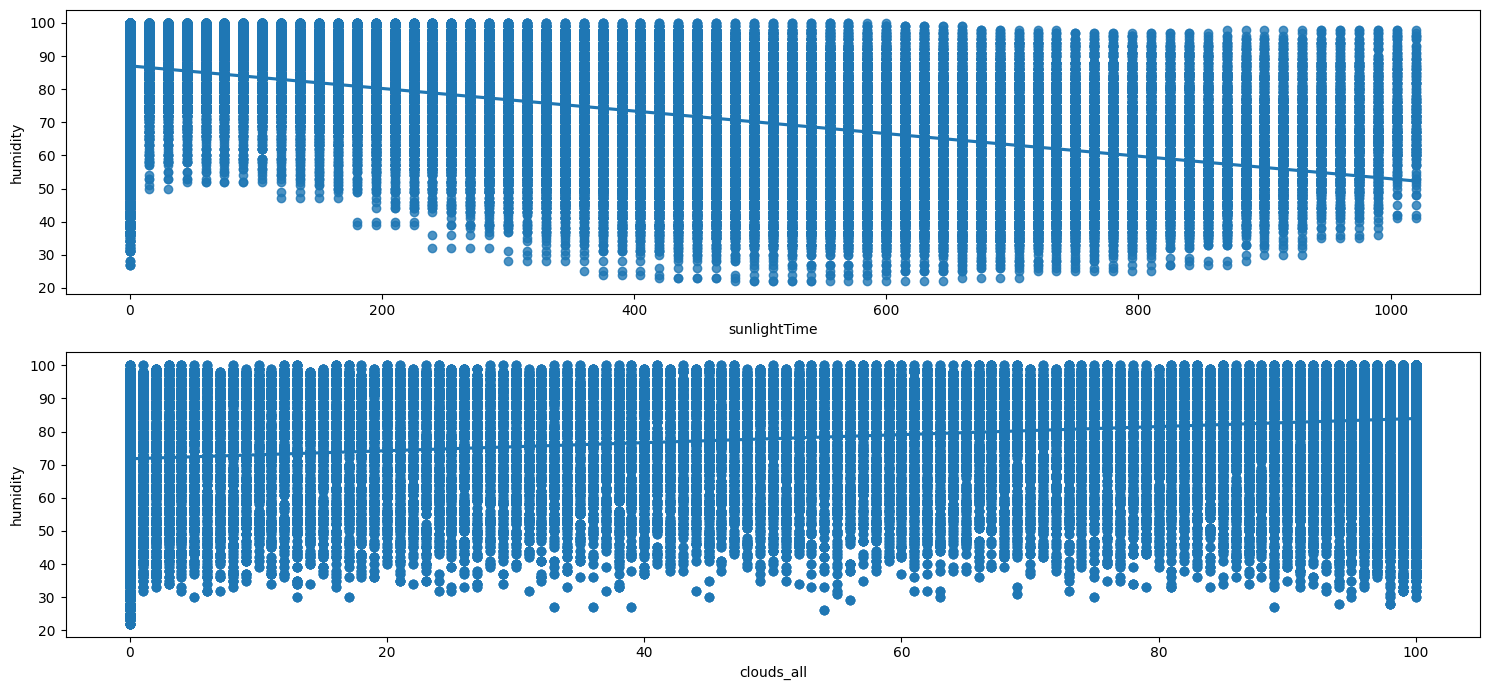

In [41]:
fig, axis = plt.subplots(2, figsize=(15, 7))

sns.regplot(ax = axis[0], data = total_data, x = "sunlightTime", y = "humidity")
sns.regplot(ax = axis[1], data = total_data, x = "clouds_all", y = "humidity")

plt.tight_layout()

plt.show()

## Feature Engineering

In [42]:
total_final_data.describe()

,year,month,day,hour,minute,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,sunlightTime,dayLength,SunlightTime/daylength,weather_type_n,isSun_n
count,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000
mean,2019.345042,6.298329,15.744481,11.498902,22.500000,573.008228,32.596538,9.790521,1015.292780,79.810566,3.937746,0.066035,0.007148,65.974387,211.721094,748.644347,0.265187,1.576493,0.519962
std,1.636537,3.376066,8.812357,6.921887,16.770552,1044.824047,52.172018,7.995428,9.585773,15.604459,1.821694,0.278913,0.069710,36.628593,273.902186,194.870208,0.329023,1.482996,0.499603
min,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-16.600000,977.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,450.000000,0.000000,0.000000,0.000000
25%,2018.000000,3.000000,8.000000,5.000000,11.250000,0.000000,0.000000,3.600000,1010.000000,70.000000,2.600000,0.000000,0.000000,34.000000,0.000000,570.000000,0.000000,0.000000,0.000000
50%,2019.000000,6.000000,16.000000,11.000000,22.500000,0.000000,1.600000,9.300000,1016.000000,84.000000,3.700000,0.000000,0.000000,82.000000,30.000000,765.000000,0.050000,1.000000,1.000000
75%,2021.000000,9.000000,23.000000,17.000000,33.750000,577.000000,46.800000,15.700000,1021.000000,92.000000,5.000000,0.000000,0.000000,100.000000,390.000000,930.000000,0.530000,3.000000,1.000000
max,2022.000000,12.000000,31.000000,23.000000,45.000000,5020.000000,229.200000,35.800000,1047.000000,100.000000,14.300000,8.090000,2.820000,100.000000,1020.000000,1020.000000,1.000000,4.000000,1.000000


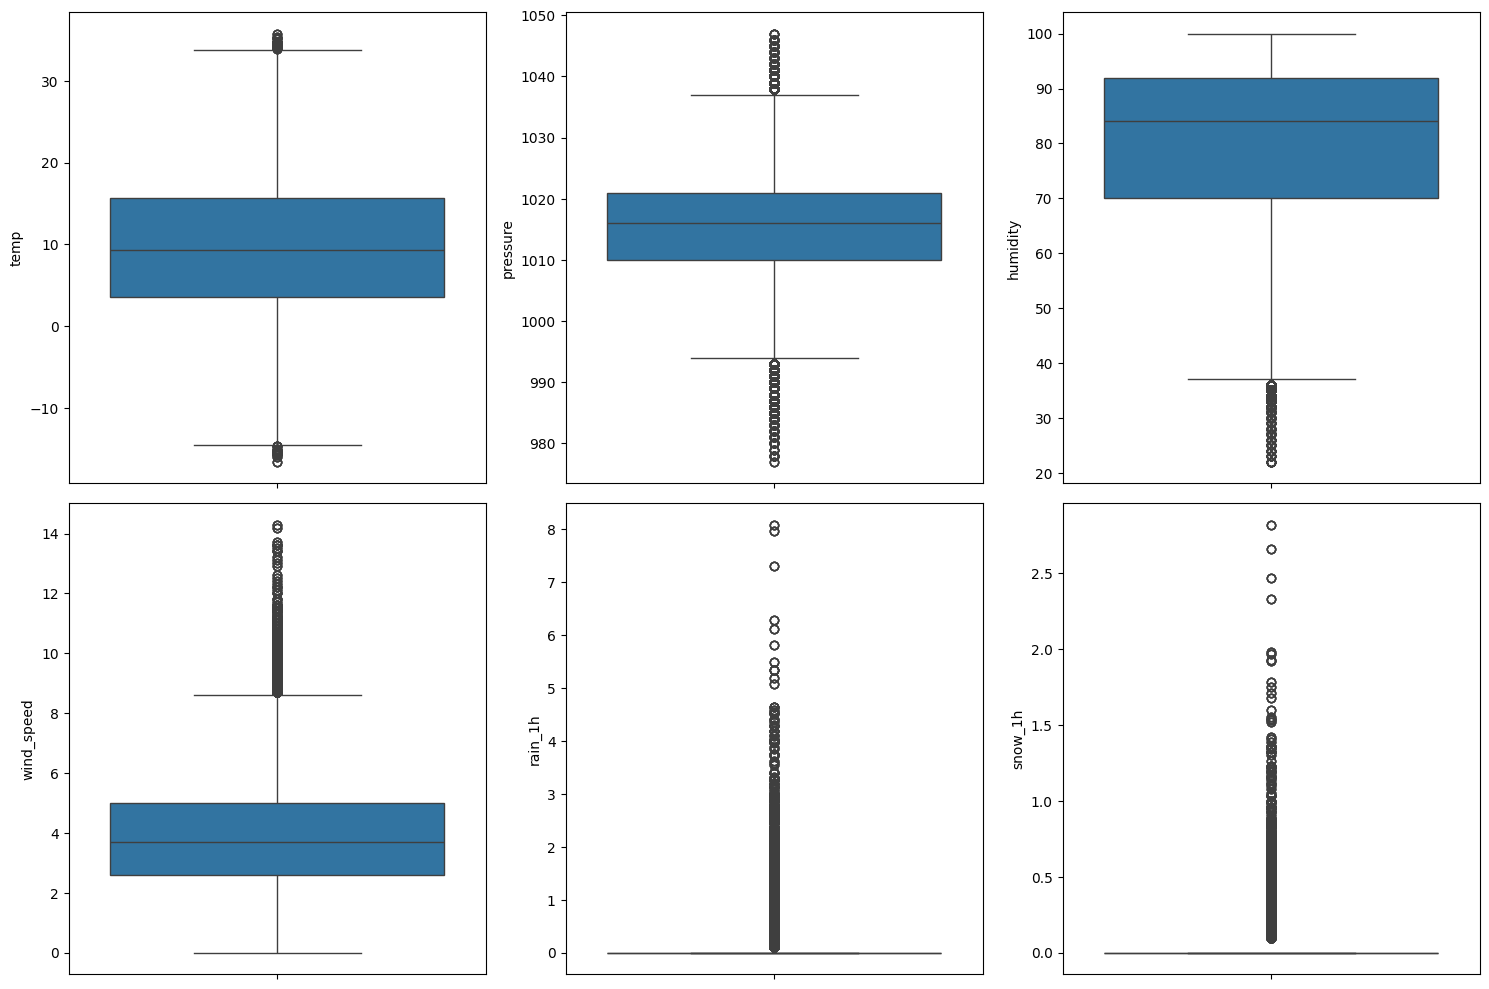

In [43]:
fig, axis = plt.subplots(2, 3, figsize = (15, 10))

sns.boxplot(ax = axis[0, 0], data = total_final_data, y = "temp")
sns.boxplot(ax = axis[0, 1], data = total_final_data, y = "pressure")
sns.boxplot(ax = axis[0, 2], data = total_final_data, y = "humidity")
sns.boxplot(ax = axis[1, 0], data = total_final_data, y = "wind_speed")
sns.boxplot(ax = axis[1, 1], data = total_final_data, y = "rain_1h")
sns.boxplot(ax = axis[1, 2], data = total_final_data, y = "snow_1h")


plt.tight_layout()

plt.show()

No se procede a analizar/imputar los outliers de las variables "rain_1h" y "snow_1h", ya que de lo contrario, al imputar los outliers todos los datos de ambas variables serían 0. Al igual que "GHI" y "sunlightTime", que al estar sesgados por los registros nocturnos, si los eliminamos a la hora de visualizar las variables en u diagrama de cajas, no presentan outliers en realidad.

In [44]:
# diferenciamos datasets para el tratamiento de outliers

no_outliers_data = total_final_data.copy()

In [45]:
# Lista de columnas de interés
columns_of_interest = ["temp", "pressure", "humidity", "wind_speed"]

# Estadísticas descriptivas para las columnas de interés
age_stat1 = no_outliers_data[columns_of_interest].describe().loc[['25%', '75%']]

# Calcular los límites y el rango intercuartílico para cada variable
for column in columns_of_interest:
    # Calcular el rango intercuartílico (IQR)
    age_iqr = age_stat1.loc['75%', column] - age_stat1.loc['25%', column]
    # Calcular los límites superior e inferior para la detección de valores atípicos
    upper_limit = age_stat1.loc['75%', column] + 1.5 * age_iqr
    lower_limit = age_stat1.loc['25%', column] - 1.5 * age_iqr

    # Imprimir los resultados
    print(f"Para la variable '{column}', los límites superior e inferior para la búsqueda de valores atípicos son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(age_iqr, 2)}")

Para la variable 'temp', los límites superior e inferior para la búsqueda de valores atípicos son 33.85 y -14.55, con un rango intercuartílico de 12.1
Para la variable 'pressure', los límites superior e inferior para la búsqueda de valores atípicos son 1037.5 y 993.5, con un rango intercuartílico de 11.0
Para la variable 'humidity', los límites superior e inferior para la búsqueda de valores atípicos son 125.0 y 37.0, con un rango intercuartílico de 22.0
Para la variable 'wind_speed', los límites superior e inferior para la búsqueda de valores atípicos son 8.6 y -1.0, con un rango intercuartílico de 2.4


In [46]:
no_outliers_data['temp'] = no_outliers_data['temp'].apply(lambda x: 4.8 if x > 33.85 or x < -14.55 else x)
no_outliers_data['pressure'] = no_outliers_data['pressure'].apply(lambda x: 1015.29 if x > 1037.5 or x < 993.5 else x)
no_outliers_data['humidity'] = no_outliers_data['humidity'].apply(lambda x: 84 if x < 37.0 else x)
no_outliers_data['wind_speed'] = no_outliers_data['wind_speed'].apply(lambda x: 2.2 if x > 8.6 else x)

no_outliers_data.head()

,year,month,day,hour,minute,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,sunlightTime,dayLength,SunlightTime/daylength,weather_type_n,isSun_n
0,2017,1,1,0,0,0,0.0,1.6,1021.0,100,4.9,0.0,0.0,100,0,450,0.0,0,0
1,2017,1,1,0,15,0,0.0,1.6,1021.0,100,4.9,0.0,0.0,100,0,450,0.0,0,0
2,2017,1,1,0,30,0,0.0,1.6,1021.0,100,4.9,0.0,0.0,100,0,450,0.0,0,0
3,2017,1,1,0,45,0,0.0,1.6,1021.0,100,4.9,0.0,0.0,100,0,450,0.0,0,0
4,2017,1,1,1,0,0,0.0,1.7,1020.0,100,5.2,0.0,0.0,100,0,450,0.0,0,0


In [9]:
total_final_data.columns

Index(['year', 'month', 'day', 'hour', 'minute', 'Energy delta[Wh]', 'GHI',
       'temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_1h',
       'clouds_all', 'sunlightTime', 'dayLength', 'SunlightTime/daylength',
       'weather_type_n', 'isSun_n'],
      dtype='object')

In [10]:
#división del dataset en datasets de entrenamiento y testeo, con outliers


predictors = ['year', 'month', 'day', 'hour', 'minute', 'GHI',
       'temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_1h',
       'clouds_all', 'sunlightTime', 'dayLength', 'SunlightTime/daylength',
       'weather_type_n', 'isSun_n']
target = 'Energy delta[Wh]'

X = total_final_data[predictors]
y = total_final_data[target]

#data with outliers no scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Select K best (k = 15)

In [16]:
selection_model = SelectKBest(f_regression, k = 15)
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_sel.head()

,month,hour,GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,sunlightTime,dayLength,SunlightTime/daylength,weather_type_n,isSun_n
0,2.0,11.0,88.8,2.6,1023.0,69.0,3.2,0.0,0.0,100.0,315.0,600.0,0.52,0.0,1.0
1,4.0,7.0,107.2,10.1,1021.0,70.0,4.5,0.0,0.0,0.0,195.0,810.0,0.24,4.0,1.0
2,12.0,11.0,26.5,3.8,1016.0,88.0,5.7,0.0,0.0,57.0,270.0,465.0,0.58,2.0,1.0
3,1.0,13.0,17.4,1.5,1028.0,72.0,3.0,0.0,0.0,64.0,390.0,495.0,0.79,2.0,1.0
4,9.0,18.0,0.0,12.8,1013.0,91.0,2.0,0.0,0.0,38.0,0.0,720.0,0.00,3.0,0.0


## Modelo a entrenar (OLGA: regresion lineal regularizada, Fer: random forest, Javi: boosting)

In [12]:
model = RandomForestRegressor (random_state=8)
model.fit(X_train_sel, y_train)

RandomForestRegressor(random_state=8)

In [13]:
y_pred = model.predict(X_test_sel)
y_pred

array([ 605.76,    0.  ,    0.  , ...,    0.  , 1378.54,    0.  ])

## Métricas de Evaluación

In [14]:
print(f"Error cuadrático medio: {mean_squared_error(y_test, y_pred)}")
print(f"Coeficiente de determinación: {r2_score(y_test, y_pred)}")
print(f"Error cuadrático medio de la raíz: {root_mean_squared_error(y_test, y_pred)}")

Error cuadrático medio: 70626.36482897398
Coeficiente de determinación: 0.9359076379458419
Error cuadrático medio de la raíz: 265.7562131521556


## Renderización de Hiperparámetros

In [15]:
def objective(trial):
    # Sugerir valores para los hiperparámetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # Crear el modelo Random Forest con los hiperparámetros sugeridos
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=8
    )

    # Entrenar el modelo
    model.fit(X_train_sel, y_train)

    # Realizar predicciones
    y_pred = model.predict(X_test_sel)

    # Calcular el Error Cuadrático Medio
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

# Crear un estudio de Optuna para optimizar los hiperparámetros
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)

# Imprimir los mejores hiperparámetros encontrados
print("Número de pruebas realizadas:", len(study.trials))
print("Mejores hiperparámetros:", study.best_params)
print("Mejor MSE:", study.best_value)

[I 2024-05-31 14:40:07,673] A new study created in memory with name: no-name-d310b4ee-3061-4d43-a6e1-0655e96a1f6c
[I 2024-05-31 14:40:42,682] Trial 1 finished with value: 72658.91186414199 and parameters: {'n_estimators': 217, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 72658.91186414199.
[I 2024-05-31 14:40:44,369] Trial 0 finished with value: 117616.64161845284 and parameters: {'n_estimators': 79, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': False}. Best is trial 1 with value: 72658.91186414199.
[I 2024-05-31 14:41:06,197] Trial 2 finished with value: 87878.82336815502 and parameters: {'n_estimators': 131, 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 72658.91186414199.
[I 2024-05-31 14:41:42,199] Trial 4 finished with value: 71317.88488061304 and p

Número de pruebas realizadas: 100
Mejores hiperparámetros: {'n_estimators': 226, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
Mejor MSE: 61284.447355626064


Número de pruebas realizadas: 100

Mejores hiperparámetros: {'n_estimators': 226, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}

Mejor MSE: 61284.447355626064

In [16]:
model = RandomForestRegressor (n_estimators=226, max_depth=20, min_samples_split=5, min_samples_leaf= 1, max_features='log2', bootstrap=False, random_state=8)
model.fit(X_train_sel, y_train)

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='log2',
                      min_samples_split=5, n_estimators=226, random_state=8)

In [17]:
y_pred = model.predict(X_test_sel)
y_pred

array([ 570.1694477,    0.       ,    0.       , ...,    0.       ,
       1280.1481094,    0.       ])

In [18]:
print(f"Error cuadrático medio: {mean_squared_error(y_test, y_pred)}")
print(f"Coeficiente de determinación: {r2_score(y_test, y_pred)}")
print(f"Error cuadrático medio de la raíz: {root_mean_squared_error(y_test, y_pred)}")

Error cuadrático medio: 61284.447355626064
Coeficiente de determinación: 0.9443852873113696
Error cuadrático medio de la raíz: 247.55695780087876


: 